# Embeddings

In [3]:
import pickle
with open("esm1b_protein_embeddings.pkl", "rb") as f:
    protein_embeddings = pickle.load(f)
    
print(len(protein_embeddings))

470


In [4]:
import pandas as pd

# Load protein sequences
pharos_load = pd.read_csv("pharos_with_ids.csv")
davis_load = pd.concat([
    pd.read_csv("../data/davis_b3_test.csv"),
    pd.read_csv("../data/davis_b3_train.csv")
], ignore_index=True)

# Get sets of protein IDs
davis_protein_ids = set(davis_load["protein_id"])
pharos_protein_ids = set(pharos_load["prot_id"])



In [5]:
# Keep only valid IDs that are actually in the embedding dictionary
davis_protein_embeddings = {pid: protein_embeddings[pid] for pid in davis_protein_ids if pid in protein_embeddings}
pharos_protein_embeddings = {pid: protein_embeddings[pid] for pid in pharos_protein_ids if pid in protein_embeddings}

print(f"{len(davis_protein_embeddings)} DAVIS proteins with embeddings")
print(f"{len(pharos_protein_embeddings)} PHAROS proteins with embeddings")


379 DAVIS proteins with embeddings
28 PHAROS proteins with embeddings


In [6]:
import pandas as pd
import numpy as np
import os
import json,pickle
from collections import OrderedDict
from rdkit import Chem
from rdkit.Chem import MolFromSmiles
import networkx as nx

from tqdm import tqdm

def atom_features(atom):
    return np.array(one_of_k_encoding_unk(atom.GetSymbol(),['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na','Ca', 'Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb','Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn', 'H','Li', 'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr','Cr', 'Pt', 'Hg', 'Pb', 'Unknown']) +
                    one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    [atom.GetIsAromatic()])

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))
def smile_to_graph(smile):
    mol = Chem.MolFromSmiles(smile)
    
    c_size = mol.GetNumAtoms()
    
    features = []
    for atom in mol.GetAtoms():
        feature = atom_features(atom)
        features.append( feature / sum(feature) )

    edges = []
    for bond in mol.GetBonds():
        edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
    g = nx.Graph(edges).to_directed()
    edge_index = []
    for e1, e2 in g.edges:
        edge_index.append([e1, e2])
        
    return c_size, features, edge_index

# import pandas as pd

# Load DAVIS drug and protein sequences
davis_drugs = pd.read_csv("davis_b3_drugs.csv")

# Load PHAROS sequences (already matched)
pharos_load = pd.read_csv("pharos_with_ids.csv")
davis_load = pd.concat([
    pd.read_csv("../data/davis_b3_test.csv"),
    pd.read_csv("../data/davis_b3_train.csv")
], ignore_index=True)
davis_load["drug_id"] = davis_load["drug_id"].astype(str).str.strip()
davis_drugs["drug_id"] = davis_drugs["drug_id"].astype(str).str.strip()

davis_drug_ids = set(davis_load["drug_id"])
pharos_drug_ids = set(pharos_load["drug_id"])

# Filter DAVIS drugs to only those used in davis_df
filtered_davis_drugs = davis_drugs[davis_drugs["drug_id"].isin(davis_drug_ids)].rename(
    columns={"drug_id": "drug", "drug_seq": "smiles"}
)[["drug", "smiles"]]
print(len(filtered_davis_drugs))

# Get PHAROS drugs
pharos_drugs = pharos_load.rename(
    columns={"drug_id": "drug", "drug_smile": "smiles"}
)[["drug", "smiles"]]
print(len(pharos_drugs))

# Combine and deduplicate
drug_smiles_dict = pd.concat([filtered_davis_drugs, pharos_drugs]) \
    .drop_duplicates("drug") \
    .set_index("drug")["smiles"] \
    .to_dict()

smile_graph = {}
for drug_id, smile in tqdm(drug_smiles_dict.items()):
    try:
        graph_data = smile_to_graph(smile)
        smile_graph[drug_id] = graph_data
    except Exception as e:
        print(f"[{drug_id}] Error: {e}")



68
495


100%|██████████| 277/277 [00:00<00:00, 1391.60it/s]


In [7]:
import sys
import os

# Add parent directory to Python path
sys.path.append(os.path.abspath(".."))

from models.ginconv import GINConvNet
import torch

# Instantiate model with default args (match training!)
model = GINConvNet()

# Load saved weights
model.load_state_dict(torch.load("saved_models/final_model_GINConvNet_davis_b3_1.pt", map_location="cpu"))

# Set to eval mode
model.eval()


/opt/anaconda3/envs/geometric/lib/python3.11/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/opt/anaconda3/envs/geometric/lib/python3.11/site-packages/torch_scatter/_version_cpu.so, 0x0006): Symbol not found: __ZN5torch3jit17parseSchemaOrNameERKNSt3__112basic_stringIcNS1_11char_traitsIcEENS1_9allocatorIcEEEEb
  Referenced from: <2711955E-91F2-3C44-B702-16E8D8D60085> /opt/anaconda3/envs/geometric/lib/python3.11/site-packages/torch_scatter/_version_cpu.so
  Expected in:     <66FB8649-BB87-3CD6-A177-462038DCAE02> /opt/anaconda3/envs/geometric/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/opt/anaconda3/envs/geometric/lib/python3.11/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: dlopen(/opt/anaconda3/envs/geometric/l

GINConvNet(
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=78, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  ))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  ))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GINConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  ))
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): GINConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_feature

In [8]:
from torch_geometric.data import Data

drug_embeddings = {}

for drug_id, (num_atoms, features, edge_index) in smile_graph.items():
    x = torch.tensor(features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    batch = torch.zeros(x.shape[0], dtype=torch.long)

    data = Data(x=x, edge_index=edge_index, batch=batch)

    with torch.no_grad():
        emb = model.extract_drug_embedding(data)
        drug_embeddings[drug_id] = emb.squeeze().numpy()


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_82733/3626892228.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  x = torch.tensor(features, dtype=torch.float)


In [9]:
print(len(drug_embeddings))
# Keep only drug_ids that exist in the embeddings dict
davis_drug_embeddings = {
    did: drug_embeddings[did]
    for did in davis_drug_ids if did in drug_embeddings
}
print(len(davis_drug_embeddings))
pharos_drug_embeddings = {
    did: drug_embeddings[did]
    for did in pharos_drug_ids if did in drug_embeddings
}
print(len(pharos_drug_embeddings))

277
68
209


# ERS NEW FORMULATION

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points
from scipy.spatial import Delaunay, ConvexHull
from sklearn.neighbors import NearestNeighbors

# === Load and merge data ===
unblinded_df = pd.read_csv("new/crossval_predictions_GINConvNet_davis_b3.csv")
blinded_df = pd.read_csv("new/concatenated_final_test_predictions.csv")
pharos_df = pd.read_csv("new/pharos_test_predictions_GINConvNet.csv")

unblinded_df = unblinded_df.rename(columns={"Predicted_Value": "Unblinded_Prediction"})
blinded_df = blinded_df.rename(columns={"Predicted_Value": "Blinded_Prediction"})
pharos_df = pharos_df.rename(columns={"Predicted_Value": "Blinded_Prediction"})

merged_df = pd.merge(
    unblinded_df[["Drug_ID", "Protein_ID", "True_Label", "Unblinded_Prediction"]],
    blinded_df[["Drug_ID", "Protein_ID", "True_Label", "Blinded_Prediction"]],
    on=["Drug_ID", "Protein_ID", "True_Label"]
)

unblinded = merged_df[["True_Label", "Unblinded_Prediction"]].values
blinded = merged_df[["True_Label", "Blinded_Prediction"]].values
pharos = pharos_df[["True_Label", "Blinded_Prediction"]].values

In [38]:
print(len(blinded))
print(len(unblinded))

27621
27621


In [53]:
# === Geometry utilities ===
def compute_distance_to_hull(polygon, delaunay, point):
    pt = Point(point)
    nearest = nearest_points(pt, polygon.boundary)[1]
    dist = pt.distance(nearest)
    is_inside = delaunay.find_simplex([point])[0] >= 0
    return dist, is_inside

# def compute_continuous_hull_distance(unblinded, blinded_subset):
#     hull = ConvexHull(unblinded)
#     polygon = Polygon(unblinded[hull.vertices])
#     delaunay = Delaunay(unblinded[hull.vertices])

#     dists = []
#     is_inside_list = []

#     for point in blinded_subset:
#         pt = Point(point)
#         nearest = nearest_points(pt, polygon.boundary)[1]
#         dist = pt.distance(nearest)
#         is_inside = delaunay.find_simplex([point])[0] >= 0
#         dists.append(dist)
#         is_inside_list.append(is_inside)

#     dists = np.array(dists)
#     is_inside = np.array(is_inside_list)

#     # Rescale inside distances: deep inside → large, near boundary → small
#     # Then flip so deepest inside = 0, boundary = max, outside = continues
#     max_inside = dists[is_inside].max() if np.any(is_inside) else 0.0

#     adjusted_dist = dists.copy()
#     adjusted_dist[is_inside] = max_inside - dists[is_inside]  # invert inside distances
#     adjusted_dist[~is_inside] = dists[~is_inside] + max_inside  # append outside distances on top

#     return adjusted_dist, is_inside

def compute_continuous_hull_distance(unblinded, blinded_subset):
    from shapely.geometry import Point
    from shapely.ops import nearest_points
    from scipy.spatial import ConvexHull, Delaunay
    import numpy as np
    from shapely.geometry import Polygon

    # === Build hull from unblinded set ===
    hull = ConvexHull(unblinded)
    polygon = Polygon(unblinded[hull.vertices])
    delaunay = Delaunay(unblinded[hull.vertices])

    # === Step 1: Compute max inside distance from unblinded set only ===
    unblinded_dists = []
    for point in unblinded:
        pt = Point(point)
        nearest = nearest_points(pt, polygon.boundary)[1]
        dist = pt.distance(nearest)
        is_inside = delaunay.find_simplex([point])[0] >= 0
        if is_inside:
            unblinded_dists.append(dist)

    max_inside = max(unblinded_dists) if unblinded_dists else 0.0

    # === Step 2: Compute adjusted distances for blinded points ===
    dists = []
    is_inside_list = []

    for point in blinded_subset:
        pt = Point(point)
        nearest = nearest_points(pt, polygon.boundary)[1]
        dist = pt.distance(nearest)
        is_inside = delaunay.find_simplex([point])[0] >= 0
        dists.append(dist)
        is_inside_list.append(is_inside)

    dists = np.array(dists)
    is_inside = np.array(is_inside_list)

    adjusted_dist = dists.copy()
    adjusted_dist[is_inside] = max_inside - dists[is_inside]   # inside: 0 = deepest
    adjusted_dist[~is_inside] = dists[~is_inside] + max_inside  # outside: continues upward

    return adjusted_dist, is_inside



def estimate_sparse_weight(unblinded, blinded_subset, k=20):
    """
    Estimate sparsity weight for each point in `blinded_subset` based on its
    k-NN density relative to the `unblinded` training data. Uses log-density
    and z-score normalization for better comparability across models.

    Returns:
        sparsity_z: array of sparsity scores (higher = more sparse)
    """
    import numpy as np
    from sklearn.neighbors import NearestNeighbors

    # Step 1: Fit k-NN on unblinded
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(unblinded)

    # Step 2: Compute unblinded point densities
    dists_unblinded, _ = nn.kneighbors(unblinded)
    density_unblinded = 1 / (dists_unblinded.mean(axis=1) + 1e-8)
    log_density_unblinded = np.log(density_unblinded + 1e-8)

    # Step 3: Compute blinded point densities
    dists_blinded, _ = nn.kneighbors(blinded_subset)
    density_blinded = 1 / (dists_blinded.mean(axis=1) + 1e-8)
    log_density_blinded = np.log(density_blinded + 1e-8)

    # Step 4: Compute z-score sparsity on log scale (higher = more sparse)
    mu = np.mean(log_density_unblinded)
    sigma = np.std(log_density_unblinded) + 1e-8
    sparsity_z = (mu - log_density_blinded) / sigma

    return sparsity_z


# === Final hybrid ERS computation ===
def compute_ERS_for_points(unblinded, blinded_subset, gamma=5.0, k=5, merged=None, use_cspd=True):
    # hull = ConvexHull(unblinded)
    # polygon = Polygon(unblinded[hull.vertices])
    # delaunay = Delaunay(unblinded[hull.vertices])


    cspd = None
    continuous_hull_distance, is_inside = compute_continuous_hull_distance(unblinded, blinded_subset)
    # Possibly override with CSPD if requested
    if use_cspd and merged is not None:
        cspd = np.abs((merged["Unblinded_Prediction"] - merged["Blinded_Prediction"]))
        dists_for_ERS = cspd
    else:
        dists_for_ERS = continuous_hull_distance

    # Sparsity
    sparsity_weights = np.maximum(estimate_sparse_weight(unblinded, blinded_subset, k=k), 1e-3) #THINK ABOUT THIS PART MORE

    # ERS
    print(len(dists_for_ERS))
    print(len(sparsity_weights))
    ERS_vals = dists_for_ERS * sparsity_weights
    print(len(ERS_vals))

    return ERS_vals, continuous_hull_distance, sparsity_weights, cspd, is_inside


# === Plotting ===
def plot_ERS_overlay(unblinded, blinded_subset, ERS_vals,type):
    hull = ConvexHull(unblinded)
    plt.figure(figsize=(8, 6))

    # Plot convex hull boundary
    for simplex in hull.simplices:
        plt.plot(unblinded[simplex, 0], unblinded[simplex, 1], 'k--', lw=1)

    # Plot unblinded points
    plt.scatter(unblinded[:, 0], unblinded[:, 1], color='gray', alpha=0.4, label='Simulated Warm Start')

    # === Set symmetric vmin/vmax to center color at 0 ===
    max_abs = np.max(np.abs(ERS_vals))  # maximum absolute ERS value

    sc = plt.scatter(
        blinded_subset[:, 0], blinded_subset[:, 1],
        c=ERS_vals, cmap='coolwarm', edgecolor='black', s=80, label='True Cold Start (Pharos)',
        # vmin=-max_abs, vmax=max_abs  # center at 0
    )

    plt.colorbar(sc, label='ERS Score')
    plt.xlabel("True Label")
    plt.ylabel("Prediction")
    plt.legend(
        loc='upper center',          # places it near the top of the plot
        bbox_to_anchor=(0.5, 1),  # (x, y) relative to axes, increase y to move up
        ncol=1,                      # keeps entries side by side like your other figure
        frameon=True
    )
    plt.title(f"Pharos True Cold Start ERS using {type} \n Overlaid on Convex Hull")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

import numpy as np

def print_ers_statistics(ERS_vals, is_inside):
    ERS_vals = np.array(ERS_vals)
    is_inside = np.array(is_inside)

    inside_vals = ERS_vals[is_inside]
    outside_vals = ERS_vals[~is_inside]

    print("=== ERS Statistics ===")
    print(f"Total Points: {len(ERS_vals)}")
    print(f"Inside Hull: {len(inside_vals)}")
    print(f"Outside Hull: {len(outside_vals)}")

    print("\n--- Overall ---")
    print(f"Mean ERS: {ERS_vals.mean():.3f}")
    print(f"Median ERS: {np.median(ERS_vals):.3f}")
    print(f"Max ERS: {ERS_vals.max():.3f}")
    print(f"Std Dev: {ERS_vals.std():.3f}")

    print("\n--- Inside Hull ---")
    print(f"Mean ERS: {inside_vals.mean():.3f}")
    print(f"Median ERS: {np.median(inside_vals):.3f}")
    print(f"Max ERS: {inside_vals.max():.3f}")
    print(f"Std Dev: {inside_vals.std():.3f}")

    print("\n--- Outside Hull ---")
    print(f"Mean ERS: {outside_vals.mean():.3f}")
    print(f"Median ERS: {np.median(outside_vals):.3f}")
    print(f"Max ERS: {outside_vals.max():.3f}")
    print(f"Std Dev: {outside_vals.std():.3f}")



(27621, 2)
[[5.        4.9522896]
 [5.        4.924177 ]
 [5.        5.0082026]
 [5.        6.0860767]
 [5.        5.0620193]]
27621
27621
27621


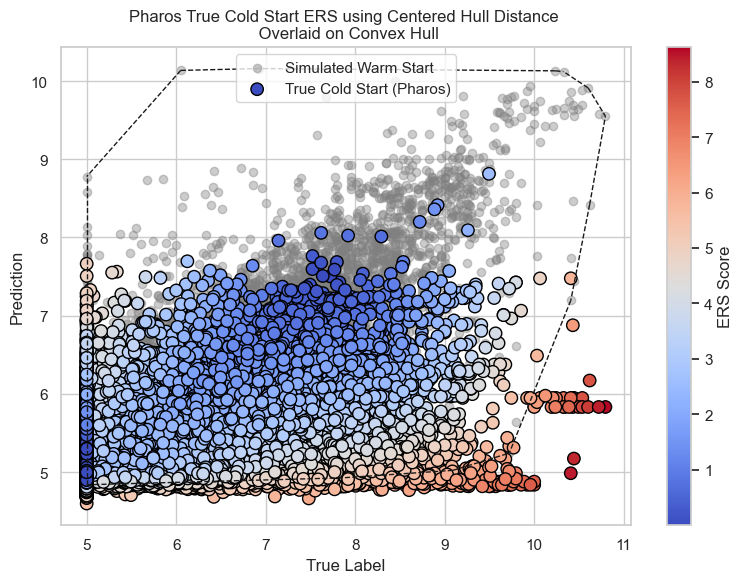

=== ERS Statistics ===
Total Points: 27621
Inside Hull: 25665
Outside Hull: 1956

--- Overall ---
Mean ERS: 1.413
Median ERS: 0.385
Max ERS: 8.626
Std Dev: 1.636

--- Inside Hull ---
Mean ERS: 1.199
Median ERS: 0.003
Max ERS: 6.130
Std Dev: 1.468

--- Outside Hull ---
Mean ERS: 4.227
Median ERS: 3.940
Max ERS: 8.626
Std Dev: 0.994
310
310
310


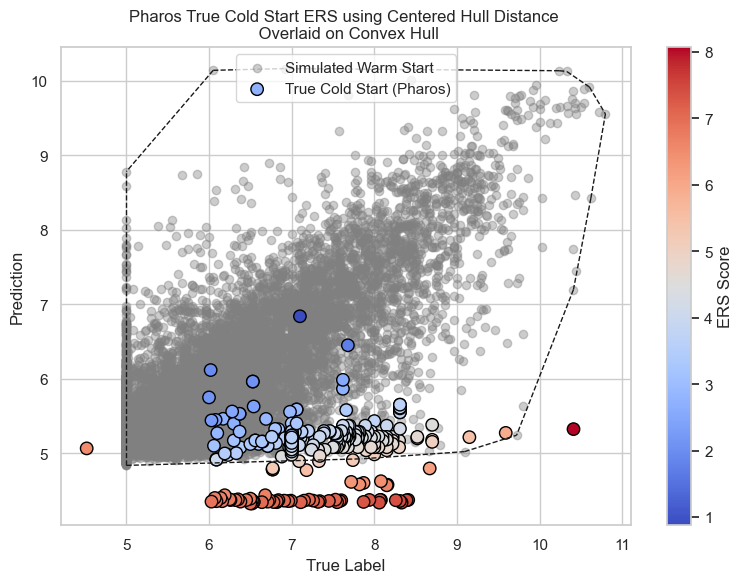

=== ERS Statistics ===
Total Points: 310
Inside Hull: 244
Outside Hull: 66

--- Overall ---
Mean ERS: 4.458
Median ERS: 4.023
Max ERS: 8.075
Std Dev: 1.372

--- Inside Hull ---
Mean ERS: 3.826
Median ERS: 3.834
Max ERS: 5.927
Std Dev: 0.634

--- Outside Hull ---
Mean ERS: 6.798
Median ERS: 6.982
Max ERS: 8.075
Std Dev: 0.632


In [54]:
# === Run ===
# ERS_vals_cspd, dists_blinded_cspd, sparsity_weights_cspd, cspds_cspd, is_inside_bl = compute_ERS_for_points(unblinded, blinded, gamma=5.0, k=20, merged =merged_df, use_cspd=True)
# plot_ERS_overlay(unblinded, blinded, ERS_vals_cspd,"CSPD")
# print_ers_statistics(ERS_vals_cspd, is_inside_bl)

print(blinded.shape)
print(blinded[:5])



ERS_vals, dists_blinded, sparsity_weights, cspds, is_inside_bl = compute_ERS_for_points(unblinded, blinded, gamma=5.0, k=20, merged =merged_df, use_cspd=False)
plot_ERS_overlay(unblinded, blinded, ERS_vals,"Centered Hull Distance")
print_ers_statistics(ERS_vals, is_inside_bl)


# === Run ===
ERS_vals_p, dists_blinded_p, sparsity_weights_p, _, is_inside_p = compute_ERS_for_points(unblinded, pharos, gamma=5.0, k=20)
plot_ERS_overlay(unblinded, pharos, ERS_vals_p, "Centered Hull Distance")
print_ers_statistics(ERS_vals_p, is_inside_p)


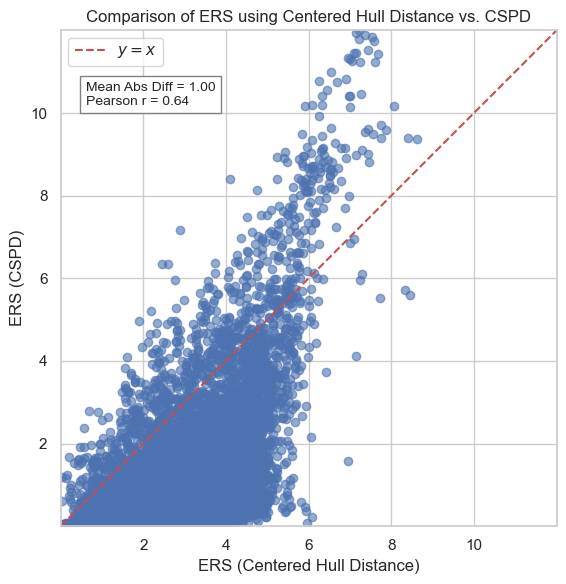

Mean absolute difference: 0.9957131376452211
Pearson correlation: 0.6376228306559943


In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Compute the difference
ERS_vals_cspd = np.array(ERS_vals_cspd)
ERS_vals_hull = np.array(ERS_vals)

# Ensure same shape
assert ERS_vals_cspd.shape == ERS_vals_hull.shape

# Define common axis limits
min_val = min(ERS_vals_hull.min(), ERS_vals_cspd.min())
max_val = max(ERS_vals_hull.max(), ERS_vals_cspd.max())
# Compute stats
diff = np.abs(ERS_vals_cspd - ERS_vals_hull)
mad = diff.mean()
corr = np.corrcoef(ERS_vals_hull, ERS_vals_cspd)[0, 1]
# Scatter plot
plt.figure(figsize=(6, 6))
plt.axis("square")
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.scatter(ERS_vals_hull, ERS_vals_cspd, alpha=0.6)
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='$y = x$')

# Annotate statistics
text_x = min_val + 0.05 * (max_val - min_val)
text_y = max_val - 0.15 * (max_val - min_val)
plt.text(text_x, text_y, f"Mean Abs Diff = {mad:.2f}\nPearson r = {corr:.2f}", fontsize=10, bbox=dict(facecolor='white', edgecolor='gray'))


plt.xlabel("ERS (Centered Hull Distance)")
plt.ylabel("ERS (CSPD)")
plt.title("Comparison of ERS using Centered Hull Distance vs. CSPD")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print mean absolute difference and correlation
diff = np.abs(ERS_vals_cspd - ERS_vals_hull)
print("Mean absolute difference:", diff.mean())
print("Pearson correlation:", np.corrcoef(ERS_vals_hull, ERS_vals_cspd)[0, 1])



Inside Hull:
  Mean absolute difference: 0.8417909677315565
  Pearson correlation: 0.6508751769612345


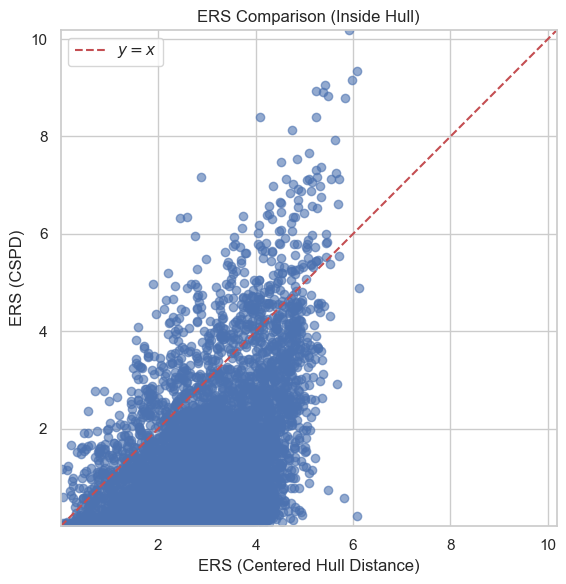


Outside Hull:
  Mean absolute difference: 3.015351425392767
  Pearson correlation: 0.8410976720346661


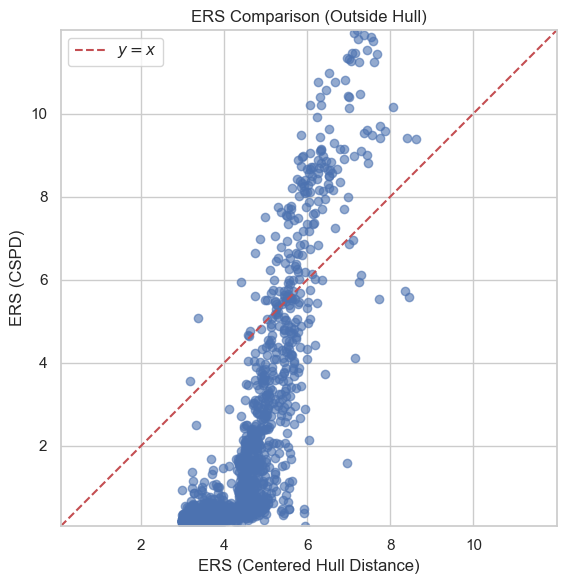

In [42]:
# Convert to arrays if needed
ERS_vals_cspd = np.array(ERS_vals_cspd)
ERS_vals_hull = np.array(ERS_vals)
is_inside_bl = np.array(is_inside_bl)  # True = inside hull

# Masked splits
inside_mask = is_inside_bl
outside_mask = ~is_inside_bl

# Compute metrics
for label, mask in [("Inside Hull", inside_mask), ("Outside Hull", outside_mask)]:
    hull_vals = ERS_vals_hull[mask]
    cspd_vals = ERS_vals_cspd[mask]
    diff = np.abs(hull_vals - cspd_vals)
    corr = np.corrcoef(hull_vals, cspd_vals)[0, 1]
    print(f"\n{label}:")
    print("  Mean absolute difference:", diff.mean())
    print("  Pearson correlation:", corr)

    # Scatter plot
    plt.figure(figsize=(6, 6))
    plt.scatter(hull_vals, cspd_vals, alpha=0.6)
    
    # Get common axis range
    min_val = min(hull_vals.min(), cspd_vals.min())
    max_val = max(hull_vals.max(), cspd_vals.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='$y = x$')
    
    # Set same axis scale
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    plt.gca().set_aspect('equal', adjustable='box')  # Force square aspect ratio
    
    plt.xlabel("ERS (Centered Hull Distance)")
    plt.ylabel("ERS (CSPD)")
    plt.title(f"ERS Comparison ({label})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


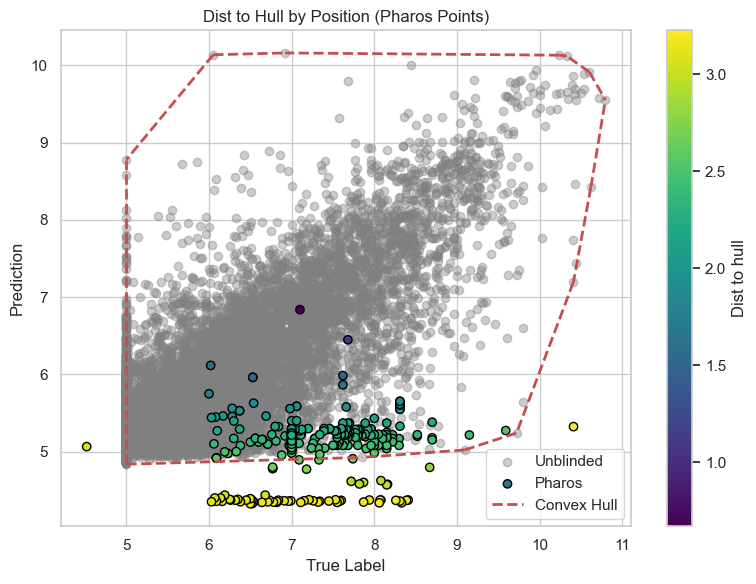

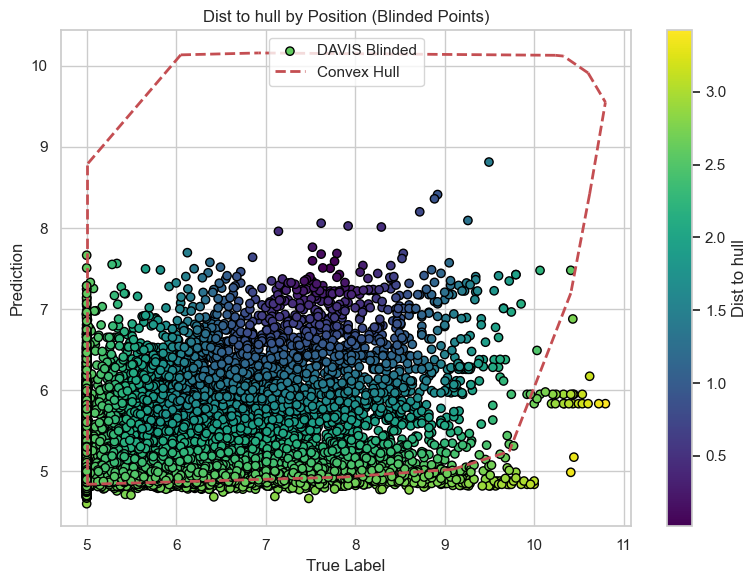

In [43]:
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

# Compute convex hull on unblinded points
hull = ConvexHull(unblinded)

plt.figure(figsize=(8, 6))

# Unblinded points in gray
plt.scatter(unblinded[:, 0], unblinded[:, 1], color='gray', alpha=0.4, label='Unblinded')

# Pharos points colored by distance to hull
sc = plt.scatter(pharos[:, 0], pharos[:, 1], c=dists_blinded_p, cmap='viridis', edgecolor='black', label='Pharos')
plt.colorbar(sc, label="Dist to hull")

# Plot convex hull edges (label only once)
for i, simplex in enumerate(hull.simplices):
    if i == 0:
        plt.plot(unblinded[simplex, 0], unblinded[simplex, 1], 'r--', linewidth=2, label='Convex Hull')
    else:
        plt.plot(unblinded[simplex, 0], unblinded[simplex, 1], 'r--', linewidth=2)

plt.title("Dist to Hull by Position (Pharos Points)")
plt.xlabel("True Label")
plt.ylabel("Prediction")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
# Pharos points colored by distance to hull
sc = plt.scatter(blinded[:, 0], blinded[:, 1], c=dists_blinded, cmap='viridis', edgecolor='black', label='DAVIS Blinded')
plt.colorbar(sc, label="Dist to hull")

# Plot convex hull edges (label only once)
for i, simplex in enumerate(hull.simplices):
    if i == 0:
        plt.plot(unblinded[simplex, 0], unblinded[simplex, 1], 'r--', linewidth=2, label='Convex Hull')
    else:
        plt.plot(unblinded[simplex, 0], unblinded[simplex, 1], 'r--', linewidth=2)

plt.title("Dist to hull by Position (Blinded Points)")
plt.xlabel("True Label")
plt.ylabel("Prediction")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




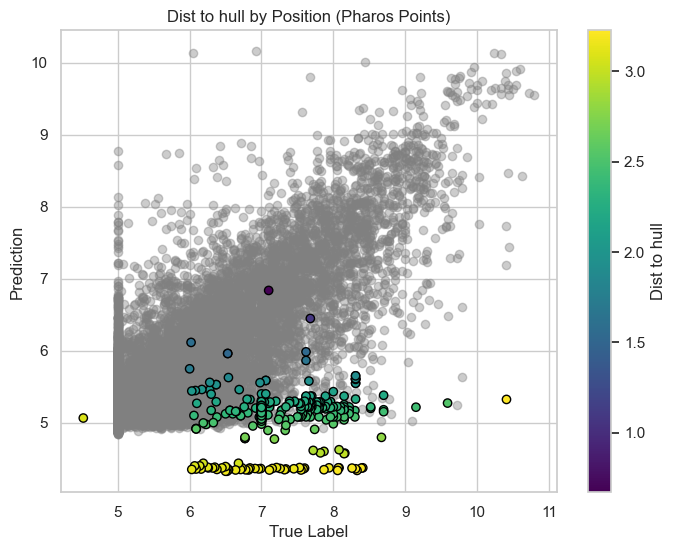

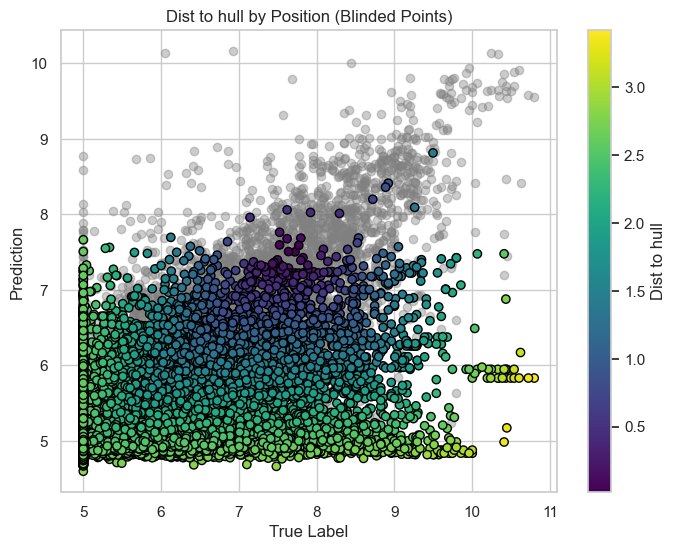

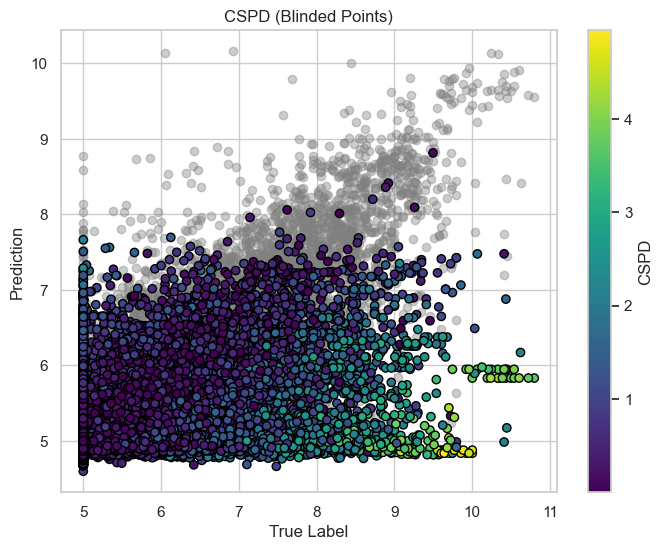

In [44]:
plt.figure(figsize=(8, 6))
plt.scatter(unblinded[:, 0], unblinded[:, 1], color='gray', alpha=0.4, label='Unblinded')
sc = plt.scatter(pharos[:, 0], pharos[:, 1], c=dists_blinded_p, cmap='viridis', edgecolor='black')
plt.colorbar(sc, label="Dist to hull")
plt.title("Dist to hull by Position (Pharos Points)")
plt.xlabel("True Label")
plt.ylabel("Prediction")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(unblinded[:, 0], unblinded[:, 1], color='gray', alpha=0.4, label='Unblinded')
sc = plt.scatter(blinded[:, 0], blinded[:, 1], c=dists_blinded, cmap='viridis', edgecolor='black')
plt.colorbar(sc, label="Dist to hull")
plt.title("Dist to hull by Position (Blinded Points)")
plt.xlabel("True Label")
plt.ylabel("Prediction")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(unblinded[:, 0], unblinded[:, 1], color='gray', alpha=0.4, label='Unblinded')
sc = plt.scatter(blinded[:, 0], blinded[:, 1], c=cspds_cspd, cmap='viridis', edgecolor='black')
plt.colorbar(sc, label="CSPD")
plt.title("CSPD (Blinded Points)")
plt.xlabel("True Label")
plt.ylabel("Prediction")
plt.grid(True)
plt.show()

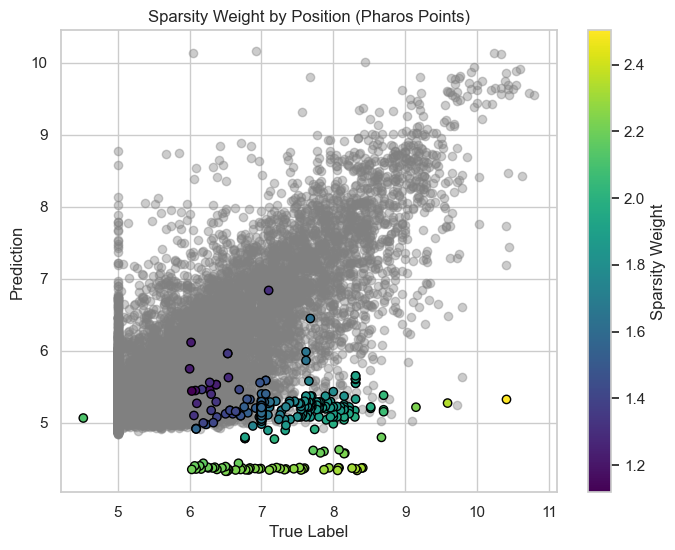

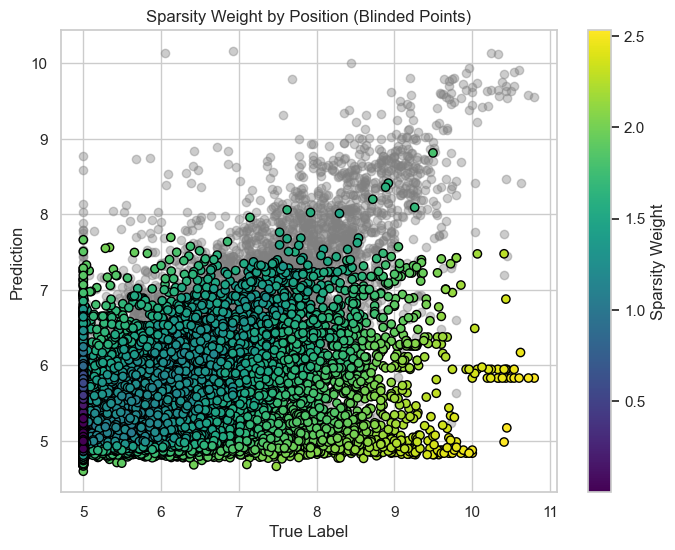

In [45]:
plt.figure(figsize=(8, 6))
plt.scatter(unblinded[:, 0], unblinded[:, 1], color='gray', alpha=0.4, label='Unblinded')
sc = plt.scatter(pharos[:, 0], pharos[:, 1], c=sparsity_weights_p, cmap='viridis', edgecolor='black')
plt.colorbar(sc, label="Sparsity Weight")
plt.title("Sparsity Weight by Position (Pharos Points)")
plt.xlabel("True Label")
plt.ylabel("Prediction")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(unblinded[:, 0], unblinded[:, 1], color='gray', alpha=0.4, label='Unblinded')
sc = plt.scatter(blinded[:, 0], blinded[:, 1], c=sparsity_weights, cmap='viridis', edgecolor='black')
plt.colorbar(sc, label="Sparsity Weight")
plt.title("Sparsity Weight by Position (Blinded Points)")
plt.xlabel("True Label")
plt.ylabel("Prediction")
plt.grid(True)
plt.show()

# SHOW THAT CSPD CORRELATES WITH signed DIST FROM CONVEX HULL 
and thus using dist from hull as proxy for cspd in pharos case is logical

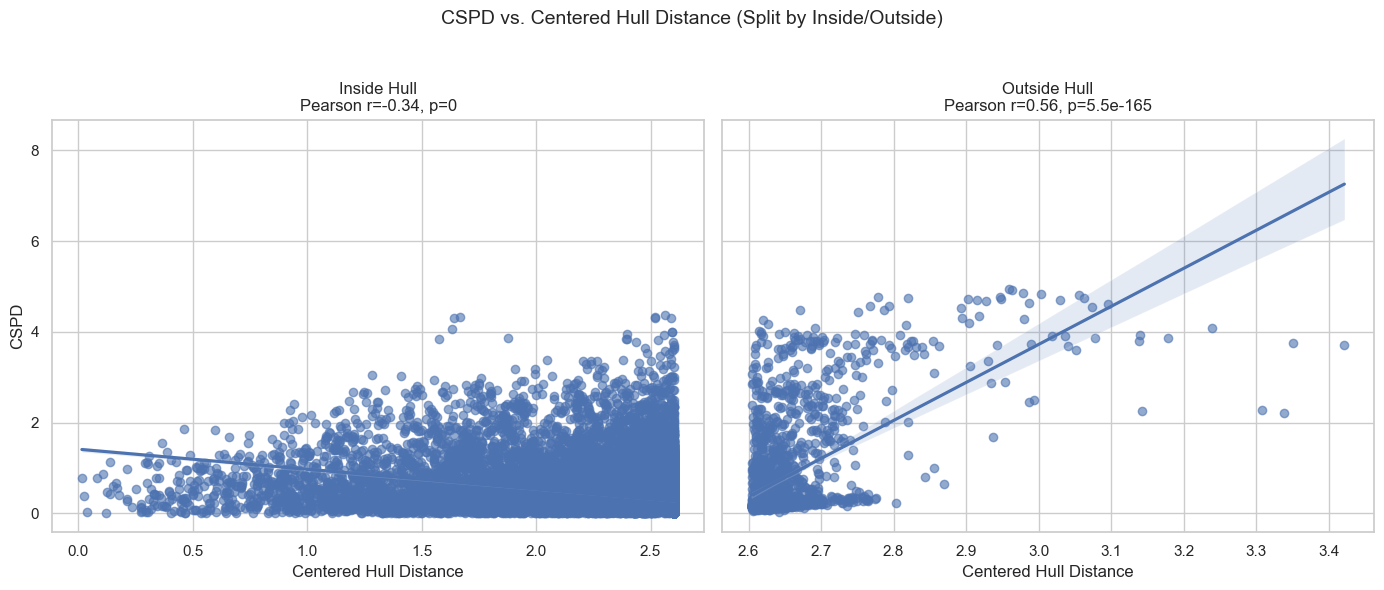

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Convert to arrays

dists_blinded_cspd = np.array(dists_blinded_cspd)
cspds_cspd = np.array(cspds_cspd)

inside_mask = is_inside_bl
outside_mask = ~is_inside_bl


sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# === Inside points ===
sns.regplot(
    x=dists_blinded_cspd[inside_mask],
    y=cspds_cspd[inside_mask],
    scatter_kws={'alpha': 0.6},
    ax=axes[0]
)
r_in, p_in = pearsonr(dists_blinded_cspd[inside_mask], cspds_cspd[inside_mask])
axes[0].set_title(f'Inside Hull\nPearson r={r_in:.2f}, p={p_in:.2g}')
axes[0].set_xlabel('Centered Hull Distance')
axes[0].set_ylabel('CSPD')

# === Outside points ===
sns.regplot(
    x=dists_blinded_cspd[outside_mask],
    y=cspds_cspd[outside_mask],
    scatter_kws={'alpha': 0.6},
    ax=axes[1]
)
r_out, p_out = pearsonr(dists_blinded_cspd[outside_mask], cspds_cspd[outside_mask])
axes[1].set_title(f'Outside Hull\nPearson r={r_out:.2f}, p={p_out:.2g}')
axes[1].set_xlabel('Centered Hull Distance')
axes[1].set_ylabel('')  # shared y-axis
 
plt.suptitle('CSPD vs. Centered Hull Distance (Split by Inside/Outside)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

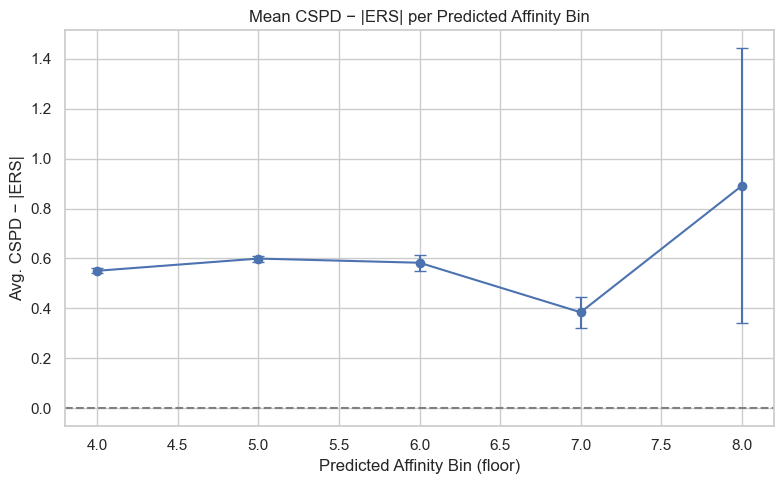

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assume:
# - ERS_vals = signed distance to hull
# - sparsity_weights = local density scores
# - cspds = CSPD = abs(ERS_vals) * sparsity_weights
# - predicted_affinities = model predictions for each point (same order)

# Sanity check
# Compute CSPD
cspds = np.abs(ERS_vals) * sparsity_weights

# Bin by integer-valued predicted affinity
aff_bin = np.floor(blinded_df["Blinded_Prediction"]).astype(int)

# Compute difference between CSPD and |ERS|
diffs = cspds - np.abs(ERS_vals)

# Create DataFrame
df = pd.DataFrame({
    "Affinity_Bin": aff_bin,
    "ERS": ERS_vals,
    "CSPD": cspds,
    "Abs_Diff": diffs
})

# Group and plot average difference per bin
grouped = df.groupby("Affinity_Bin")["Abs_Diff"].agg(["mean", "count", "std"])
grouped = grouped[grouped["count"] >= 5]  # drop small bins for stability

plt.figure(figsize=(8, 5))
plt.errorbar(
    grouped.index,
    grouped["mean"],
    yerr=grouped["std"] / np.sqrt(grouped["count"]),  # SEM
    fmt='o-', capsize=4
)
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Predicted Affinity Bin (floor)")
plt.ylabel("Avg. CSPD − |ERS|")
plt.title("Mean CSPD − |ERS| per Predicted Affinity Bin")
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_97690/210324814.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = bin_df.groupby("bin").mean()


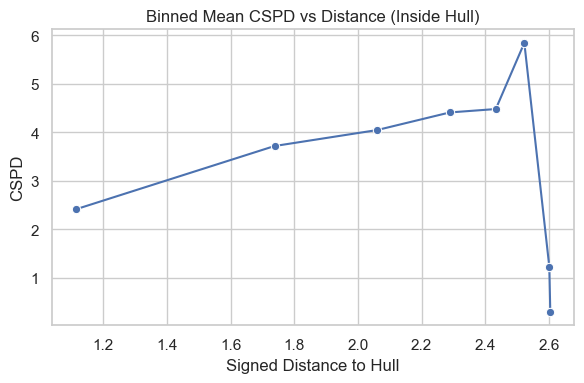

In [ ]:
import pandas as pd
bin_df = pd.DataFrame({
    "distance": dists_blinded[inside_mask],
    "cspd": cspds[inside_mask]
})
bin_df["bin"] = pd.qcut(bin_df["distance"], q=20, duplicates="drop")
bin_means = bin_df.groupby("bin").mean()

plt.figure(figsize=(6,4))
sns.lineplot(data=bin_means, x="distance", y="cspd", marker="o")
plt.title("Binned Mean CSPD vs Distance (Inside Hull)")
plt.xlabel("Signed Distance to Hull")
plt.ylabel("CSPD")
plt.grid(True)
plt.tight_layout()
plt.show()


# CSVS
turn ERS and chr into csvs

(#inside pts/#total pts)(avg ERS inside) + (#outside pts/#total pts)(avg ERS outside) but would weight the inside points heavily

so maybe CSVS_model = CHR * mean_ERS_outside
CHR is the fraction of outside points

In [19]:
def compute_model_level_csvs(ERS_vals, is_inside):
    ERS_vals = np.array(ERS_vals)
    is_inside = np.array(is_inside)

    # Boolean masks
    inside_mask = is_inside
    outside_mask = ~is_inside

    # Count totals
    num_total = len(ERS_vals)
    num_inside = inside_mask.sum()
    num_outside = outside_mask.sum()

    # Compute CHR
    CHR = num_outside / num_total if num_total > 0 else 0.0

    # Means (safe fallback to NaN if no points)
    mean_ERS_inside = ERS_vals[inside_mask].mean() if num_inside > 0 else np.nan
    mean_ERS_outside = ERS_vals[outside_mask].mean() if num_outside > 0 else np.nan

    # === Option 1: Weighted Average (original proposal) ===
    CSVS_weighted = (
        (num_inside / num_total) * mean_ERS_inside +
        (num_outside / num_total) * mean_ERS_outside
        if num_total > 0 else np.nan
    )

    # === Option 2: CHR-weighted outside ERS (recommended) ===
    CSVS_chr_scaled = CHR * mean_ERS_outside if mean_ERS_outside is not np.nan else np.nan

    return {
        "CHR": CHR,
        "Mean_ERS_inside": mean_ERS_inside,
        "Mean_ERS_outside": mean_ERS_outside,
        "CSVS_weighted": CSVS_weighted,
        "CSVS_chr_scaled": CSVS_chr_scaled
    }

In [20]:
print("CSVS DAVIS UNBLINDED")
results = compute_model_level_csvs(ERS_vals, is_inside_bl)
print("CHR:", results["CHR"])
print("Mean ERS (inside):", results["Mean_ERS_inside"])
print("Mean ERS (outside):", results["Mean_ERS_outside"])
print("CSVS (weighted):", results["CSVS_weighted"])
print("CSVS (CHR × mean outside ERS):", results["CSVS_chr_scaled"])

print("CSVS PHAROS")
results_p = compute_model_level_csvs(ERS_vals_p, is_inside_p)
print("CHR:", results_p["CHR"])
print("Mean ERS (inside):", results_p["Mean_ERS_inside"])
print("Mean ERS (outside):", results_p["Mean_ERS_outside"])
print("CSVS (weighted):", results_p["CSVS_weighted"])
print("CSVS (CHR × mean outside ERS):", results_p["CSVS_chr_scaled"])

CSVS DAVIS UNBLINDED
CHR: 0.07081568371890952
Mean ERS (inside): 1.19865259893377
Mean ERS (outside): 4.226974436097147
CSVS (weighted): 1.4131052803533986
CSVS (CHR × mean outside ERS): 0.29933608475457146
CSVS PHAROS
CHR: 0.2129032258064516
Mean ERS (inside): 3.825594578856291
Mean ERS (outside): 6.797833371793376
CSVS (weighted): 4.458393805739671
CSVS (CHR × mean outside ERS): 1.4472806533495575


# Confidence

In [21]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import wasserstein_distance

def compute_csvs_generalizability_confidence_v2(
    user_df, blinded_df, unblinded_df,
    user_drug_embeddings, user_protein_embeddings,
    blinded_drug_embeddings, blinded_protein_embeddings,
    gamma_emb=0.4, gamma_shift=0.4, gamma_geom=0.2,
    affinity_col="Predicted_Value", max_wasserstein=5.0
):
    """
    Improved version: computes CSVS generalizability confidence for a user's cold-start dataset.

    Parameters:
    - user_df: user's dataset with Drug_ID, Protein_ID, Predicted_Value
    - blinded_df: benchmark blinded set used in CSVS estimation
    - unblinded_df: training set (used to construct convex hull)
    - *_embeddings: dicts with separated embeddings for user and blinded data
    - gamma_*: weights for component contributions
    - max_wasserstein: normalization bound for prediction shift

    Returns:
    - dict with overall confidence and component-level scores
    """

    # ---- 1. Embedding similarity ----
    drug_sims, prot_sims = [], []
    for _, row in user_df.iterrows():
        did, pid = row["Drug_ID"], row["Protein_ID"]

        if did in user_drug_embeddings and pid in user_protein_embeddings:
            d_emb = user_drug_embeddings[did].reshape(1, -1)
            p_emb = user_protein_embeddings[pid].reshape(1, -1)

            blinded_d_embs = np.stack([
                blinded_drug_embeddings[d] for d in blinded_df["Drug_ID"]
                if d in blinded_drug_embeddings
            ])
            blinded_p_embs = np.stack([
                blinded_protein_embeddings[p] for p in blinded_df["Protein_ID"]
                if p in blinded_protein_embeddings
            ])

            if len(blinded_d_embs) > 0:
                d_sim = cosine_similarity(d_emb, blinded_d_embs).mean()
                drug_sims.append(d_sim)
            if len(blinded_p_embs) > 0:
                p_sim = cosine_similarity(p_emb, blinded_p_embs).mean()
                prot_sims.append(p_sim)

    emb_score = np.mean(drug_sims + prot_sims) if (drug_sims and prot_sims) else 0.0

    # ---- 2. Prediction distribution shift ----
    user_preds = user_df[affinity_col].values
    blinded_preds = blinded_df[affinity_col].values
    shift_score = wasserstein_distance(user_preds, blinded_preds) / max_wasserstein
    shift_score = 1.0 - min(shift_score, 1.0)

    # ---- 3. Geometry: fraction inside convex hull ----
    try:
        hull_points = unblinded_df[["True_Label", "Predicted_Value"]].dropna().values
        if len(hull_points) >= 3:
            hull = ConvexHull(hull_points)
            polygon = Polygon(hull_points[hull.vertices])
            user_points = user_df[[affinity_col]].copy()
            user_points["True_Label"] = unblinded_df["True_Label"].mean()
            user_points = user_points[["True_Label", affinity_col]].values

            inside_mask = np.array([polygon.covers(Point(p)) for p in user_points])
            frac_inside = inside_mask.mean()
        else:
            frac_inside = 0.0
    except Exception:
        frac_inside = 0.0

    geom_score = frac_inside

    # ---- Final confidence score ----
    confidence = gamma_emb * emb_score + gamma_shift * shift_score + gamma_geom * geom_score
    result = {
        "confidence": round(confidence, 4),
        "embedding_similarity": round(emb_score, 4),
        "prediction_distribution_alignment": round(shift_score, 4),
        "geometry_overlap": round(geom_score, 4)
    }
    return result

In [22]:
pharos_df = pharos_df.rename(columns={"drug_id": "Drug_ID"})
pharos_df = pharos_df.rename(columns={"prot_id": "Protein_ID"})
pharos_df["Drug_ID"] = pharos_df["Drug_ID"].astype(str)
pharos_df["Protein_ID"] = pharos_df["Protein_ID"].astype(str)
blinded_df["Drug_ID"] = blinded_df["Drug_ID"].astype(str)
blinded_df["Protein_ID"] = blinded_df["Protein_ID"].astype(str)
unblinded_df["Drug_ID"] = unblinded_df["Drug_ID"].astype(str)
unblinded_df["Protein_ID"] = unblinded_df["Protein_ID"].astype(str)
print(blinded_df.columns)
print(unblinded_df.columns)
print(pharos_df.columns)
blinded_df = blinded_df.rename(columns={"Blinded_Prediction": "Predicted_Value"})
unblinded_df = unblinded_df.rename(columns={"Unblinded_Prediction": "Predicted_Value"})
pharos_df = pharos_df.rename(columns={"Blinded_Prediction": "Predicted_Value"})

result = compute_csvs_generalizability_confidence_v2(
    user_df=pharos_df,
    blinded_df=blinded_df,
    unblinded_df=unblinded_df,
    user_drug_embeddings=pharos_drug_embeddings,
    user_protein_embeddings=pharos_protein_embeddings,
    blinded_drug_embeddings=davis_drug_embeddings,
    blinded_protein_embeddings=davis_protein_embeddings
)

print(result)

Index(['Drug_ID', 'Protein_ID', 'True_Label', 'Blinded_Prediction', 'Fold'], dtype='object')
Index(['Drug_ID', 'Protein_ID', 'True_Label', 'Unblinded_Prediction'], dtype='object')
Index(['Drug_ID', 'Protein_ID', 'True_Label', 'Blinded_Prediction'], dtype='object')
{'confidence': 0.7837, 'embedding_similarity': 0.6075, 'prediction_distribution_alignment': 0.9501, 'geometry_overlap': 0.8032}


see if theres a way to validate... maybe split up the pharos set? and compute csvs for each and then see how confidence ranks them? naa

# INFERENCE
Need to infer csvs for each point in pharos using what i have for davis. (then validate by checking against csvs as i have defined it for pharos (which uses true affinity))

In [23]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def prepare_davis_triplet_df(davis_df, protein_embeddings, drug_embeddings):
    triplets = []

    for _, row in davis_df.iterrows():
        pid = row["Protein_ID"]
        did = row["Drug_ID"]
        pred_aff = row["Predicted_Value"]
        if pid in protein_embeddings and did in drug_embeddings:
            triplets.append({
                "Protein_ID": pid,
                "Drug_ID": did,
                "Predicted_Value": pred_aff,
                "ERS": row["ERS"],
                "prot_emb": protein_embeddings[pid],
                "drug_emb": drug_embeddings[did]
            })

    triplet_df = pd.DataFrame(triplets)
    return triplet_df

def build_similarity_matrices(pharos_df, davis_triplet_df, protein_embeddings, drug_embeddings):
    pharos_prot_ids = pharos_df["Protein_ID"].unique()
    davis_prot_ids = davis_triplet_df["Protein_ID"].unique()
    pharos_drug_ids = pharos_df["Drug_ID"].unique()
    davis_drug_ids = davis_triplet_df["Drug_ID"].unique()

    # Protein similarity matrix
    prot_matrix = cosine_similarity(
        [protein_embeddings[pid] for pid in pharos_prot_ids],
        [protein_embeddings[dpid] for dpid in davis_prot_ids]
    )

    # Drug similarity matrix
    drug_matrix = cosine_similarity(
        [drug_embeddings[did] for did in pharos_drug_ids],
        [drug_embeddings[ddid] for ddid in davis_drug_ids]
    )

    return (
        pd.DataFrame(prot_matrix, index=pharos_prot_ids, columns=davis_prot_ids),
        pd.DataFrame(drug_matrix, index=pharos_drug_ids, columns=davis_drug_ids)
    )

def build_neighborhood_df_for_pharos_point_fast(
    pharos_point,
    davis_triplet_df,
    protein_sim_matrix,
    drug_sim_matrix,
    top_k=5,
    weights=(0.4, 0.4, 0.2)  # (protein, drug, affinity)
):
    """
    Fast neighborhood builder using precomputed similarity matrices.
    """
    pid, did, pred_aff = pharos_point["Protein_ID"], pharos_point["Drug_ID"], pharos_point["Predicted_Value"]

    if pid not in protein_sim_matrix.index or did not in drug_sim_matrix.index:
        return None

    # Extract similarities from precomputed matrices
    prot_sims = protein_sim_matrix.loc[pid].reindex(davis_triplet_df["Protein_ID"].values).values
    drug_sims = drug_sim_matrix.loc[did].reindex(davis_triplet_df["Drug_ID"].values).values
    #aff_sims = -np.abs(davis_triplet_df["Predicted_Value"].values - pred_aff) 
    aff_diff = np.abs(davis_triplet_df["Predicted_Value"] - pred_aff)

    prot_sims = (prot_sims - prot_sims.min()) / (prot_sims.max() - prot_sims.min())
    drug_sims = (drug_sims - drug_sims.min()) / (drug_sims.max() - drug_sims.min())
    aff_sims = 1 - (aff_diff / aff_diff.max())

    #weights each portion of the similarity score
    total_sims = (
        weights[0] * prot_sims +
        weights[1] * drug_sims +
        weights[2] * aff_sims
    )

    top_k_idx = np.argsort(total_sims)[-top_k:]

    neighborhood_df = davis_triplet_df.iloc[top_k_idx].copy()
    neighborhood_df["similarity"] = total_sims[top_k_idx]

    return neighborhood_df.reset_index(drop=True)


# def assign_ERS_by_similarity(neighborhood_df):
#     """
#     Weighted average ERS of neighbors, weighted by similarity.
#     """
#     if neighborhood_df is None or neighborhood_df.empty:
#         return np.nan, np.nan

#     dvs = neighborhood_df["ERS"].values
#     print("neighborhood dvs:", dvs)
#     sims = neighborhood_df["similarity"].values
#     print("neighborhood sims:", sims)

#     inferred_ERS = np.average(dvs, weights=sims + 1e-8)
#     confidence = sims.mean()  # or max(sims) for a conservative metric

#     return inferred_ERS, confidence

def assign_ERS_by_similarity(neighborhood_df, alpha=1.0):
    """
    Weighted average ERS of neighbors, weighted by similarity, 
    plus a penalty for low similarity to the Davis set.
    """
    if neighborhood_df is None or neighborhood_df.empty:
        return np.nan, np.nan

    dvs = neighborhood_df["ERS"].values
    sims = neighborhood_df["similarity"].values

    # Weighted average as before
    weighted_ERS = np.average(dvs, weights=sims + 1e-8)
    
    
    #RELOOOK HEREEE
    
    # Dissimilarity penalty: higher if max similarity is low
    penalty = 1 - np.max(sims)  # You can also try 1 - np.mean(sims)
    
    # Final inferred ERS: add penalty term
    inferred_ERS = weighted_ERS + alpha * penalty

    # Confidence can still be the mean or max similarity
    confidence = sims.mean()  # or max(sims) for a conservative metric

    return inferred_ERS, confidence


In [187]:
# === Ensure string types for ID columns ===
pharos_df["Protein_ID"] = pharos_df["Protein_ID"].astype(str)
pharos_df["Drug_ID"] = pharos_df["Drug_ID"].astype(str)
blinded_df["Protein_ID"] = blinded_df["Protein_ID"].astype(str)
blinded_df["Drug_ID"] = blinded_df["Drug_ID"].astype(str)
blinded_df.rename(columns={"Blinded_Prediction": "Predicted_Value"}, inplace=True)

blinded_df["DTH"] = dists_blinded
blinded_df["ERS"] = ERS_vals
blinded_df["CSPD"] = cspds
blinded_df["Sparsity_Weight"] = sparsity_weights
blinded_df["Is_Inside"] = is_inside_bl

# === Assign ERS values to blinded_df ===
outside_mask = ~blinded_df["Is_Inside"]
davis_outside_df = blinded_df[outside_mask]

# === Prepare DAVIS triplet dataframe (with embeddings) ===
davis_triplet_df = prepare_davis_triplet_df(davis_outside_df, protein_embeddings, drug_embeddings)

# === Precompute similarity matrices ===
protein_sim_matrix, drug_sim_matrix = build_similarity_matrices(
    pharos_df, davis_triplet_df, protein_embeddings, drug_embeddings
)

# === Build neighborhoods using fast method ===
neighborhoods = {}

pharos_df.rename(columns={"Blinded_Prediction": "Predicted_Value"}, inplace=True)
for _, pharos_point in pharos_df.iterrows():
    key = (
        pharos_point["Drug_ID"],
        pharos_point["Protein_ID"],
        pharos_point["Predicted_Value"]
    )
    
    n_df = build_neighborhood_df_for_pharos_point_fast(
        pharos_point=pharos_point,
        davis_triplet_df=davis_triplet_df,
        protein_sim_matrix=protein_sim_matrix,
        drug_sim_matrix=drug_sim_matrix,
        top_k=5,
        weights=(0.33, 0.33, 0.33)
    )
    
    if n_df is not None:
        neighborhoods[key] = n_df

#Infer DVs
inferred_ERSs = []
ERS_confidences = []

for _, row in pharos_df.iterrows():
    key = (
        row["Drug_ID"],
        row["Protein_ID"],
        row["Predicted_Value"]
    )
    n_df_i = neighborhoods.get(key, None)
    ERS, conf = assign_ERS_by_similarity(n_df_i)
    inferred_ERSs.append(ERS)
    ERS_confidences.append(conf)

pharos_df["Inferred_ERS"] = inferred_ERSs
pharos_df["ERS_Confidence"] = ERS_confidences

print(inferred_ERSs)
pharos_df["Inferred_CSVS_alt"] = pharos_df["Inferred_ERS"] * pharos_df["ERS_Confidence"]
# Add true ERS
pharos_df["ERS"] = ERS_vals_p


[4.792532599401428, 3.576720532431456, 3.6035814330750844, 3.973543260014166, 3.9918202551217172, 3.9007707282122075, 3.8859006979147255, 4.601531745199573, 4.123731170080802, 4.229024667322101, 4.415090506147942, 3.6640328112541845, 4.115983363600875, 3.9159875349850912, 3.984900352184904, 4.539661842791869, 4.188296823586362, 3.9325682423692983, 4.638318178411588, 3.893388833863786, 3.7533354587567316, 4.284357828387319, 4.195828698325712, 4.0042075961449495, 4.079657448974423, 3.677805235592194, 4.663429849822631, 4.248328172832854, 4.502562938130424, 5.364508730178876, 4.013249880511643, 4.8316770518258, 5.073338746249558, 4.494592959830253, 4.456064843149193, 4.170875161026803, 3.847857916513619, 4.454817705278146, 4.473412600045105, 4.403516058584502, 4.46454343761518, 4.122085399562169, 4.1214560853152555, 4.606435452632496, 3.6640328112541845, 4.056539139720599, 3.833535220985995, 4.912833542500096, 4.000238753952817, 3.8912003284875505, 4.601531745199573, 4.859029076809935, 4.

Text(0.5, 1.0, 'Should trend upward if ERS matches model uncertainty')

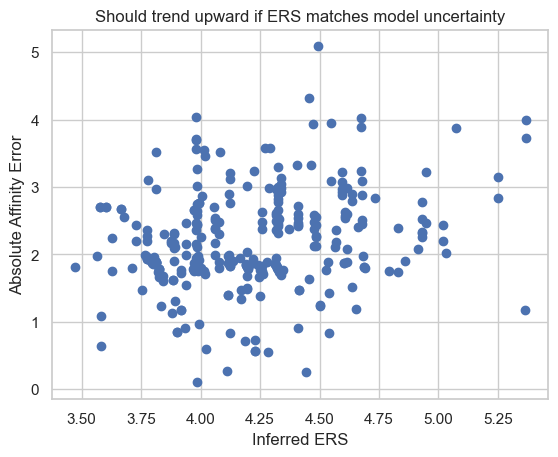

In [25]:
plt.scatter(pharos_df["Inferred_ERS"], np.abs(pharos_df["Predicted_Value"] - pharos_df["True_Label"]))
plt.xlabel("Inferred ERS")
plt.ylabel("Absolute Affinity Error")
plt.title("Should trend upward if ERS matches model uncertainty")


Spearman: SignificanceResult(statistic=0.19357972939141221, pvalue=0.0006102300314907178)
Pearson: PearsonRResult(statistic=0.20066545491256885, pvalue=0.0003779304620633592)


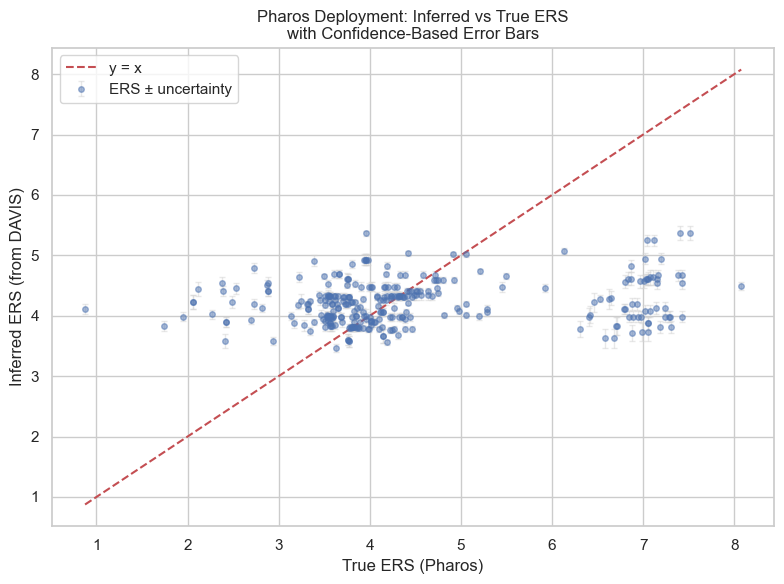

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr

# Correlation
print("Spearman:", spearmanr(pharos_df["ERS"], pharos_df["Inferred_ERS"]))
print("Pearson:", pearsonr(pharos_df["ERS"], pharos_df["Inferred_ERS"]))

# === Scatter Plot with Confidence Bars ===
plt.figure(figsize=(8, 6))

# Sort for layering: larger errors behind smaller ones
sorted_df = pharos_df.sort_values("ERS_Confidence", ascending=False)

# Plot points with vertical error bars
plt.errorbar(
    x=sorted_df["ERS"],
    y=sorted_df["Inferred_ERS"],
    yerr=np.abs(1 - sorted_df["ERS_Confidence"]),  # inverse confidence as error bar
    fmt='o',
    ecolor='lightgray',
    elinewidth=1,
    alpha=0.5,
    capsize=2,
    markersize=4,
    label="ERS ± uncertainty"
)

# Diagonal identity line
min_val = min(pharos_df["ERS"].min(), pharos_df["Inferred_ERS"].min())
max_val = max(pharos_df["ERS"].max(), pharos_df["Inferred_ERS"].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')

# Labels and formatting
plt.xlabel("True ERS (Pharos)")
plt.ylabel("Inferred ERS (from DAVIS)")
plt.title("Pharos Deployment: Inferred vs True ERS\nwith Confidence-Based Error Bars")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


count    230.000000
mean       0.931172
std        0.366144
min        0.124282
25%        0.662251
50%        0.873435
75%        1.098017
max        1.913332
dtype: float64


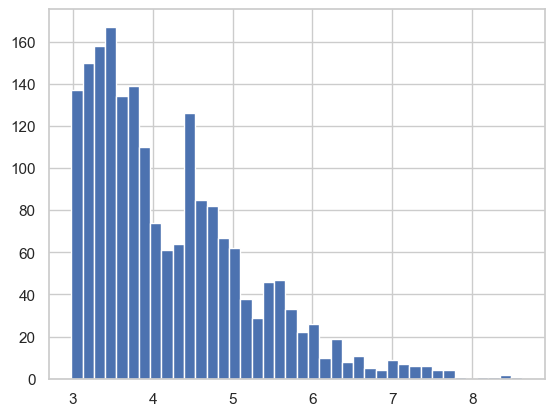

In [27]:
davis_triplet_df["ERS"].hist(bins=40)

# For each neighborhood, compute std of ERS
neighborhood_ERS_stds = [n["ERS"].std() for n in neighborhoods.values()]
print(pd.Series(neighborhood_ERS_stds).describe())

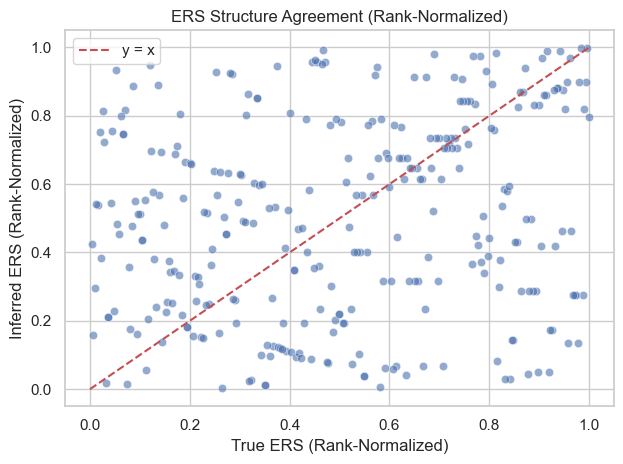

In [28]:


from scipy.stats import rankdata
import seaborn as sns
import matplotlib.pyplot as plt

pharos_df["ERS_rank"] = rankdata(pharos_df["ERS"]) / len(pharos_df)
pharos_df["Inferred_ERS_rank"] = rankdata(pharos_df["Inferred_ERS"]) / len(pharos_df)

sns.scatterplot(data=pharos_df, x="ERS_rank", y="Inferred_ERS_rank", alpha=0.6)
plt.plot([0, 1], [0, 1], 'r--', label='y = x')
plt.xlabel("True ERS (Rank-Normalized)")
plt.ylabel("Inferred ERS (Rank-Normalized)")
plt.title("ERS Structure Agreement (Rank-Normalized)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

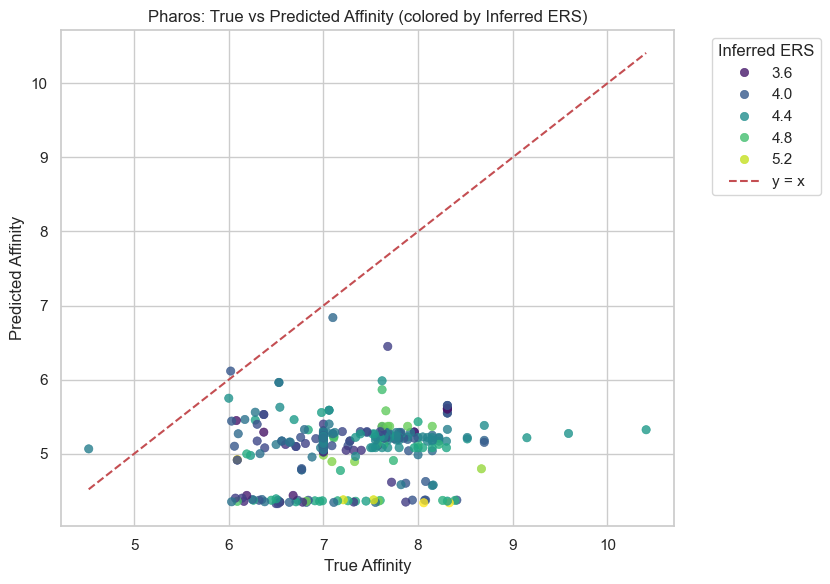

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 6))
scatter = sns.scatterplot(
    data=pharos_df,
    x="True_Label",
    y="Predicted_Value",
    hue="Inferred_ERS",
    palette="viridis",
    alpha=0.8,
    edgecolor=None
)

# Diagonal reference line
plt.plot([pharos_df["True_Label"].min(), pharos_df["True_Label"].max()],
         [pharos_df["True_Label"].min(), pharos_df["True_Label"].max()],
         'r--', label="y = x")

plt.xlabel("True Affinity")
plt.ylabel("Predicted Affinity")
plt.title("Pharos: True vs Predicted Affinity (colored by Inferred ERS)")
plt.grid(True)
plt.tight_layout()
plt.legend(title="Inferred ERS", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

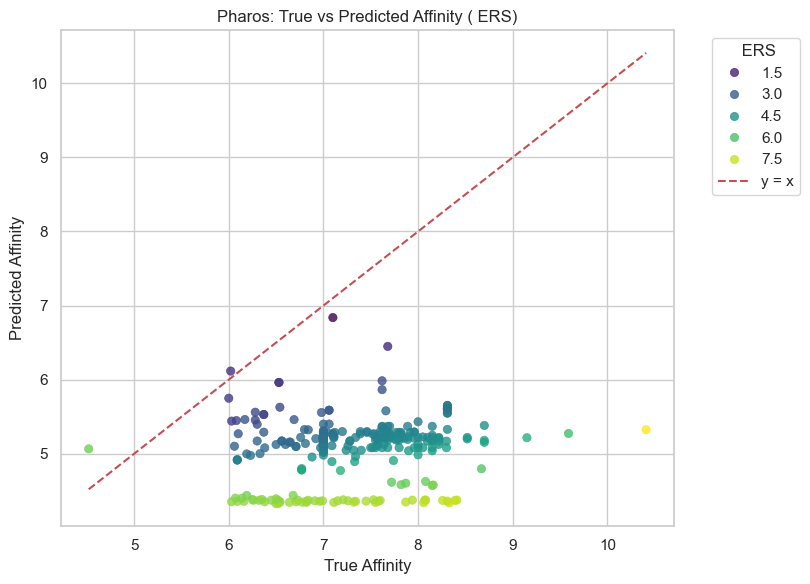

In [30]:
import seaborn as sns

plt.figure(figsize=(7, 6))
scatter = sns.scatterplot(
    data=pharos_df,
    x="True_Label",
    y="Predicted_Value",
    hue="ERS",
    palette="viridis",
    alpha=0.8,
    edgecolor=None
)

# Diagonal reference line
plt.plot([pharos_df["True_Label"].min(), pharos_df["True_Label"].max()],
         [pharos_df["True_Label"].min(), pharos_df["True_Label"].max()],
         'r--', label="y = x")

plt.xlabel("True Affinity")
plt.ylabel("Predicted Affinity")
plt.title("Pharos: True vs Predicted Affinity ( ERS)")
plt.grid(True)
plt.tight_layout()
plt.legend(title=" ERS", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# nn Model

In [31]:
import torch
import torch.nn as nn

class DVWithInteraction(nn.Module):
    def __init__(self, drug_dim, prot_dim, embed_dim=128, use_aux_dim=2, hidden_dim=512, dropout=0.3):
        super().__init__()
        self.use_aux_dim = use_aux_dim
        self.embed_dim = embed_dim

        # Projection to common space
        self.proj_drug = nn.Linear(drug_dim, embed_dim)
        self.proj_prot = nn.Linear(prot_dim, embed_dim)

        # Final input dim = d_proj + p_proj + interaction1 + interaction2 + affinity + aux
        input_dim = embed_dim * 4 + 1 + use_aux_dim

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, drug_emb, prot_emb, affinity, side_info=None):
        if side_info is None:
            side_info = torch.zeros(drug_emb.size(0), self.use_aux_dim, device=drug_emb.device)

        # Project to shared embedding space
        d_proj = self.proj_drug(drug_emb)
        p_proj = self.proj_prot(prot_emb)

        # Compute interactions
        abs_diff = torch.abs(d_proj - p_proj)
        prod = d_proj * p_proj

        # Combine all features
        x = torch.cat([d_proj, p_proj, abs_diff, prod, affinity, side_info], dim=1)
        return self.net(x)


In [32]:
def build_dataset(df, drug_embeddings, protein_embeddings, side_feature_cols=None):
    X_drug, X_prot, X_aff, y_ERS = [], [], [], []
    X_side = []

    for _, row in df.iterrows():
        did, pid = row["Drug_ID"], row["Protein_ID"]
        if did in drug_embeddings and pid in protein_embeddings:
            X_drug.append(drug_embeddings[did])
            X_prot.append(protein_embeddings[pid])
            X_aff.append([row["Predicted_Value"]])
            y_ERS.append(row["ERS"])

            if side_feature_cols:
                X_side.append([row[col] for col in side_feature_cols])

    return (
        torch.tensor(np.array(X_drug), dtype=torch.float32),
        torch.tensor(np.array(X_prot), dtype=torch.float32),
        torch.tensor(np.array(X_aff), dtype=torch.float32),
        torch.tensor(np.array(y_ERS), dtype=torch.float32).unsqueeze(1),
        torch.tensor(np.array(X_side), dtype=torch.float32) if side_feature_cols else None
    )

In [33]:
print(davis_outside_df.columns)

# Prepare data
X_drug, X_prot, X_aff, y, X_side = build_dataset(
    davis_outside_df,
    drug_embeddings,
    protein_embeddings,
    side_feature_cols=["CSPD", "Sparsity_Weight"]
)

# Initialize model
model_inf = DVWithInteraction(
    drug_dim=X_drug.shape[1],
    prot_dim=X_prot.shape[1],
    embed_dim=128,                   # you can tune this
    use_aux_dim=X_side.shape[1]      # e.g., 2 for CSPD + sparsity
)

optimizer = torch.optim.Adam(model_inf.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

# Training loop
for epoch in range(100):
    model_inf.train()
    preds = model_inf(X_drug, X_prot, X_aff, side_info=X_side)
    loss = loss_fn(preds, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

Index(['Drug_ID', 'Protein_ID', 'True_Label', 'Predicted_Value', 'Fold', 'DTH',
       'ERS', 'CSPD', 'Sparsity_Weight', 'Is_Inside'],
      dtype='object')
Epoch 0 | Loss: 15.2607
Epoch 10 | Loss: 1.1407
Epoch 20 | Loss: 1.0692
Epoch 30 | Loss: 1.0541
Epoch 40 | Loss: 1.0475
Epoch 50 | Loss: 1.0569
Epoch 60 | Loss: 1.0136
Epoch 70 | Loss: 1.0072
Epoch 80 | Loss: 0.9657
Epoch 90 | Loss: 0.8921


In [34]:
X_drug_p, X_prot_p, X_aff_p, _, _ = build_dataset(pharos_df, drug_embeddings, protein_embeddings)
model_inf.eval()
with torch.no_grad():
    inferred_ERSs = model_inf(X_drug_p, X_prot_p, X_aff_p).squeeze().numpy()

pharos_df["Inferred_ERS_model"] = inferred_ERSs

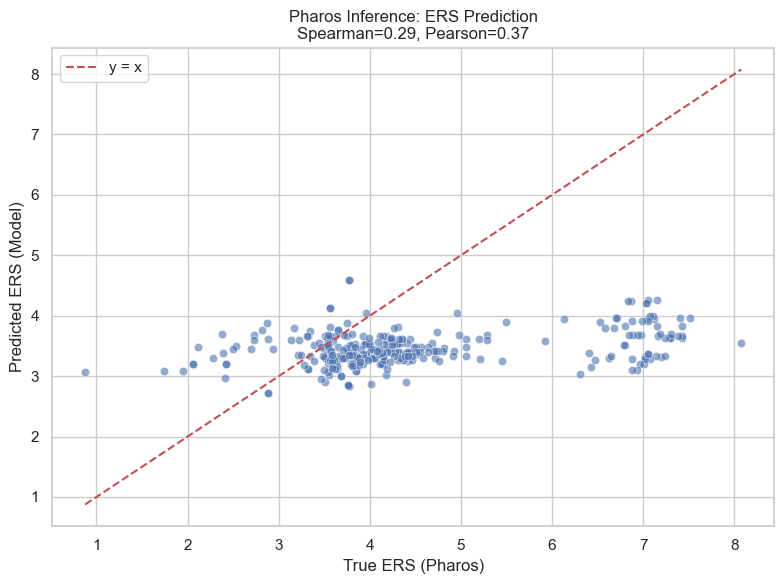

In [35]:
# Compute correlation using the real data from pharos_df
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation
spearman_corr, _ = spearmanr(pharos_df["ERS"], pharos_df["Inferred_ERS_model"])
pearson_corr, _ = pearsonr(pharos_df["ERS"], pharos_df["Inferred_ERS_model"])

# Plot: True vs Predicted ERS
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pharos_df, x="ERS", y="Inferred_ERS_model", alpha=0.6)

min_val = min(pharos_df["ERS"].min(), pharos_df["Inferred_ERS_model"].min())
max_val = max(pharos_df["ERS"].max(), pharos_df["Inferred_ERS_model"].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')

plt.xlabel("True ERS (Pharos)")
plt.ylabel("Predicted ERS (Model)")
plt.title(f"Pharos Inference: ERS Prediction\nSpearman={spearman_corr:.2f}, Pearson={pearson_corr:.2f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

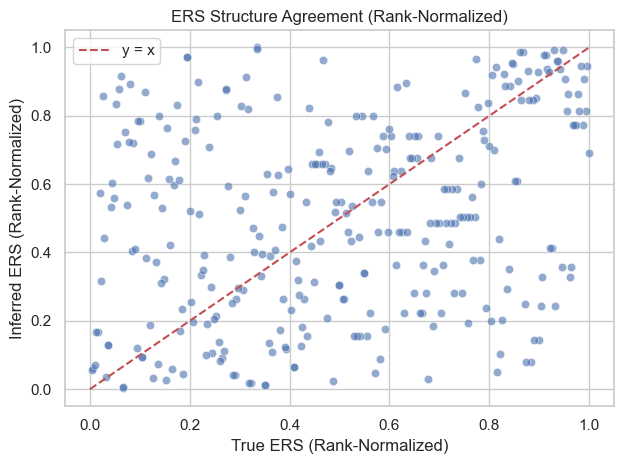

In [36]:
from scipy.stats import rankdata
import seaborn as sns
import matplotlib.pyplot as plt

pharos_df["ERS_rank"] = rankdata(pharos_df["ERS"]) / len(pharos_df)
pharos_df["Inferred_ERS_rank"] = rankdata(pharos_df["Inferred_ERS_model"]) / len(pharos_df)

sns.scatterplot(data=pharos_df, x="ERS_rank", y="Inferred_ERS_rank", alpha=0.6)
plt.plot([0, 1], [0, 1], 'r--', label='y = x')
plt.xlabel("True ERS (Rank-Normalized)")
plt.ylabel("Inferred ERS (Rank-Normalized)")
plt.title("ERS Structure Agreement (Rank-Normalized)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

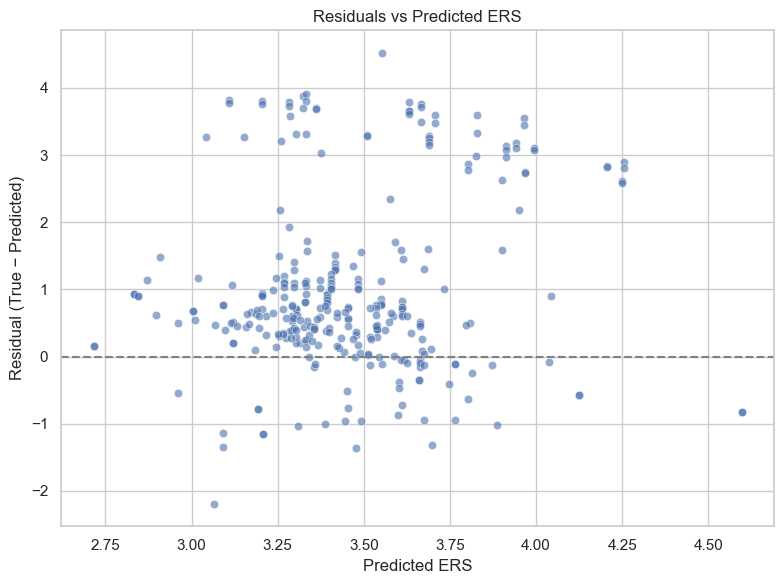

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

pharos_df["Residual_ERS"] = pharos_df["ERS"] - pharos_df["Inferred_ERS_model"]
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pharos_df,
    x="Inferred_ERS_model",
    y="Residual_ERS",
    alpha=0.6
)
plt.axhline(0, linestyle="--", color="gray")
plt.xlabel("Predicted ERS")
plt.ylabel("Residual (True − Predicted)")
plt.title("Residuals vs Predicted ERS")
plt.grid(True)
plt.tight_layout()
plt.show()

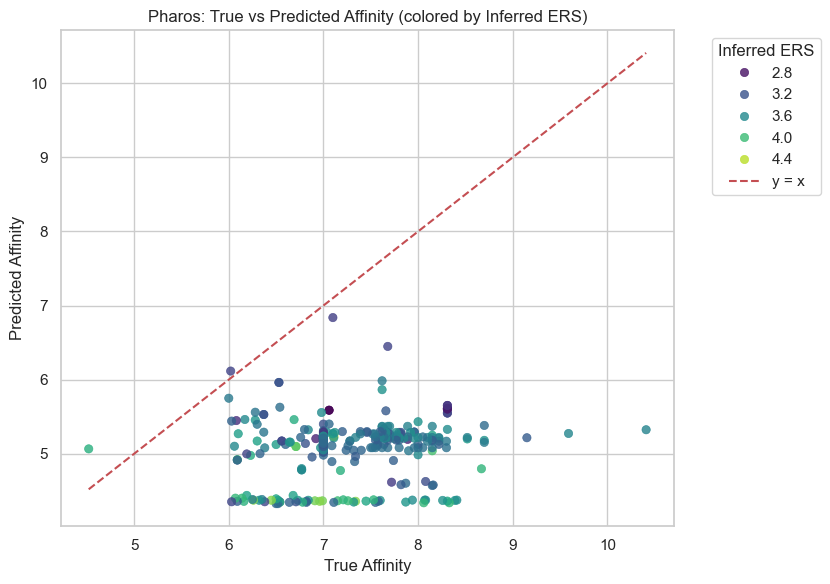

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
#filtered_df = pharos_df[pharos_df["Predicted_Value"] < 5]

plt.figure(figsize=(7, 6))
scatter = sns.scatterplot(
    data=pharos_df,
    x="True_Label",
    y="Predicted_Value",
    hue="Inferred_ERS_model",
    palette="viridis",
    alpha=0.8,
    edgecolor=None
)

# Diagonal reference line
plt.plot([pharos_df["True_Label"].min(), pharos_df["True_Label"].max()],
         [pharos_df["True_Label"].min(), pharos_df["True_Label"].max()],
         'r--', label="y = x")

plt.xlabel("True Affinity")
plt.ylabel("Predicted Affinity")
plt.title("Pharos: True vs Predicted Affinity (colored by Inferred ERS)")
plt.grid(True)
plt.tight_layout()
plt.legend(title="Inferred ERS", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# Arties Idea

Plot similarity vs percent error

In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics.pairwise import cosine_similarity

# === Compute similarity of each protein to the training proteins ===
def build_protein_similarity_cache(protein_embeddings, train_proteins, save_path="protein_similarity_cache.pkl"):
    similarity_cache = {}
    train_embeddings = {
        pid: protein_embeddings[pid]
        for pid in train_proteins if pid in protein_embeddings
    }
    for pid in protein_embeddings:
        if pid not in similarity_cache:
            query = protein_embeddings[pid].reshape(1, -1)
            train_vecs = np.array(list(train_embeddings.values()))
            if train_vecs.size == 0:
                similarity_cache[pid] = np.nan
            else:
                sim = cosine_similarity(query, train_vecs)[0]
                similarity_cache[pid] = np.mean(sim)  # or np.max(sim)

    with open(save_path, "wb") as f:
        pickle.dump(similarity_cache, f)

    return similarity_cache

def build_similarity_cache_pharos_to_davis(pharos_embeddings, davis_embeddings, save_path="pharos_to_davis_similarity.pkl"):
    similarity_cache = {}
    davis_vecs = np.array(list(davis_embeddings.values()))
    for pid, emb in pharos_embeddings.items():
        if emb is not None and davis_vecs.size > 0:
            sim = cosine_similarity([emb], davis_vecs)[0]
            similarity_cache[pid] = np.mean(sim)  # or np.max(sim)
        else:
            similarity_cache[pid] = np.nan

    with open(save_path, "wb") as f:
        pickle.dump(similarity_cache, f)

    return similarity_cache


def predict_expected_error_protein_sim_quantiles(similarity_array, quantile_bins, quantile_means):
    expected_errors = []
    for sim in similarity_array:
        assigned = False
        for i, interval in enumerate(quantile_bins):
            if sim >= interval.left and sim <= interval.right:
                expected_errors.append(quantile_means[i])
                assigned = True
                break
        if not assigned:
            expected_errors.append(np.nan)
    return np.array(expected_errors)


def predict_expected_error(similarity, model):
    """Predict expected 95th percentile error from similarity using trained quantile model."""
    X_new = np.column_stack([similarity, similarity**2])
    X_new = sm.add_constant(X_new, has_constant='add')
    return model.predict(X_new)

In [207]:
train_proteins = merged_df["Protein_ID"]
similarity_cache = build_protein_similarity_cache(protein_embeddings, train_proteins)

davis_outside = davis_outside_df.rename(columns={"Predicted_Value":"Blinded_Prediction"})
unblinded_df = unblinded_df.rename(columns={"Predicted_Value":"Unblinded_Prediction"})
davis_outside["Drug_ID"] = davis_outside["Drug_ID"].astype(str)
unblinded_df["Drug_ID"] = unblinded_df["Drug_ID"].astype(str)
merged_df_outside = pd.merge(
    unblinded_df[["Drug_ID", "Protein_ID", "True_Label", "Unblinded_Prediction"]],
    davis_outside[["Drug_ID", "Protein_ID", "True_Label", "Blinded_Prediction"]],
    on=["Drug_ID", "Protein_ID", "True_Label"]
)
df = merged_df_outside.copy()
print(df.columns)
print(len(df))
df["Percent_Error"] = 100 * np.abs(df["Unblinded_Prediction"] - df["Blinded_Prediction"]) / df["True_Label"]
print(df["Percent_Error"].mean())

df["Protein_Similarity"] = df["Protein_ID"].map(similarity_cache)

Index(['Drug_ID', 'Protein_ID', 'True_Label', 'Unblinded_Prediction',
       'Blinded_Prediction'],
      dtype='object')
1956
6.224056343940424


In [208]:

# Use qcut to assign protein similarity quantiles
df["Similarity_Quantile"] = pd.qcut(df["Protein_Similarity"], q=10, duplicates='drop')

# Group by quantile and compute mean error in each
quantile_error_lookup = df.groupby("Similarity_Quantile")["Percent_Error"].mean()
quantile_bins = df["Similarity_Quantile"].cat.categories  # stores interval bounds


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_97690/2661017241.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantile_error_lookup = df.groupby("Similarity_Quantile")["Percent_Error"].mean()


In [209]:
pharos_sim_cache = build_similarity_cache_pharos_to_davis(
    pharos_protein_embeddings, davis_protein_embeddings
)

# === Step 3: Add similarity and percent error ===
pharos_df["Protein_Similarity"] = pharos_df["Protein_ID"].map(pharos_sim_cache)
pharos_df["Percent_Error"] = 100 * np.abs(pharos_df["True_Label"] - pharos_df["Predicted_Value"])/pharos_df["True_Label"]


In [210]:
# Fit quadratic quantile regression
X = df["Protein_Similarity"]
y = df["Percent_Error"]
X_poly = sm.add_constant(np.column_stack([X, X**2]))
model = sm.QuantReg(y, X_poly).fit(q=0.50)


In [214]:
pharos_df["Expected_Error"] = predict_expected_error(pharos_df["Protein_Similarity"].values, model)
print(pharos_df["Expected_Error"].describe())
pharos_df["Adjusted_Prediction"] = pharos_df["Predicted_Value"] * (1 + pharos_df["Expected_Error"] / 100)


pharos_df["Expected_Error_Protein"] = predict_expected_error_protein_sim_quantiles(
    pharos_df["Protein_Similarity"].values,
    quantile_bins,
    quantile_error_lookup.values
)

pharos_df["Adjusted_Prediction_Protein"] = pharos_df["Predicted_Value"] * (1 + pharos_df["Expected_Error_Protein"] / 100)


count    310.000000
mean       2.426562
std        0.441303
min        2.249737
25%        2.303037
50%        2.303037
75%        2.309080
max        5.072209
Name: Expected_Error, dtype: float64


In [212]:
print("\n📊 Expected % Error by Protein Similarity Quantile:")
for bin_label, err in zip(quantile_bins, quantile_error_lookup):
    print(f"{bin_label}: {err:.2f}%")



📊 Expected % Error by Protein Similarity Quantile:
(0.897, 0.9637]: 6.04%
(0.9637, 0.9679]: 5.81%
(0.9679, 0.9701]: 4.03%
(0.9701, 0.9717]: 5.10%
(0.9717, 0.9729]: 4.95%
(0.9729, 0.9736]: 6.61%
(0.9736, 0.9744]: 6.33%
(0.9744, 0.9753]: 5.98%
(0.9753, 0.9766]: 8.89%
(0.9766, 0.9797]: 8.53%


🔵 Original Predictions:
   RMSE = 2.312
   MAE  = 2.193

🔴 Adjusted Predictions (+Expected % Error):
   RMSE = 2.196
   MAE  = 2.072


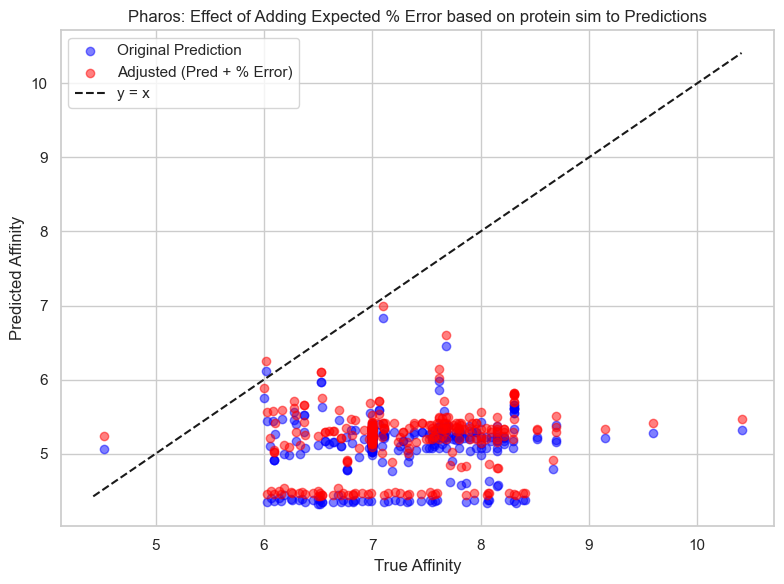

In [213]:
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Make sure columns exist
true = pharos_df["True_Label"]
pred = pharos_df["Predicted_Value"]
adjusted = pharos_df["Adjusted_Prediction"]

# Compute metrics
rmse_original = np.sqrt(mean_squared_error(true, pred))
mae_original = mean_absolute_error(true, pred)

rmse_adjusted = np.sqrt(mean_squared_error(true, adjusted))
mae_adjusted = mean_absolute_error(true, adjusted)

# Print
print(f"🔵 Original Predictions:")
print(f"   RMSE = {rmse_original:.3f}")
print(f"   MAE  = {mae_original:.3f}")

print(f"\n🔴 Adjusted Predictions (+Expected % Error):")
print(f"   RMSE = {rmse_adjusted:.3f}")
print(f"   MAE  = {mae_adjusted:.3f}")

# Step 2: Plot original and adjusted predictions
plt.figure(figsize=(8, 6))

# Original points
plt.scatter(
    pharos_df["True_Label"],
    pharos_df["Predicted_Value"],
    color="blue",
    alpha=0.5,
    label="Original Prediction"
)

# Adjusted points
plt.scatter(
    pharos_df["True_Label"],
    pharos_df["Adjusted_Prediction"],
    color="red",
    alpha=0.5,
    label="Adjusted (Pred + % Error)"
)

# y = x line
min_val = min(pharos_df["True_Label"].min(), pharos_df["Adjusted_Prediction"].min())
max_val = max(pharos_df["True_Label"].max(), pharos_df["Adjusted_Prediction"].max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label="y = x")

# Labels
plt.xlabel("True Affinity")
plt.ylabel("Predicted Affinity")
plt.title("Pharos: Effect of Adding Expected % Error based on protein sim to Predictions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import pickle

# === Compute similarity of each drug to the training drugs ===
def build_drug_similarity_cache(drug_embeddings, train_drugs, save_path="drug_similarity_cache.pkl"):
    similarity_cache = {}
    train_embeddings = {
        did: drug_embeddings[did]
        for did in train_drugs if did in drug_embeddings
    }
    print(len(train_embeddings))

    train_vecs = np.array(list(train_embeddings.values()))
    for did, query_vec in drug_embeddings.items():
        if did not in similarity_cache:
            if query_vec is None or train_vecs.size == 0:
                similarity_cache[did] = np.nan
            else:
                sim = cosine_similarity([query_vec], train_vecs)[0]
                similarity_cache[did] = np.mean(sim)  # or np.max(sim)

    with open(save_path, "wb") as f:
        pickle.dump(similarity_cache, f)

    # Check example IDs and values
    return similarity_cache

# === Step 1: Set training drugs ===
train_drugs = set(merged_df["Drug_ID"].astype(str))
merged_df["Drug_ID"] = merged_df["Drug_ID"].astype(str)

similarity_cache = build_drug_similarity_cache(drug_embeddings, train_drugs)

# === Step 3: Apply to DataFrame ===
df = merged_df.copy()
df["Percent_Error"] = 100 * np.abs(df["Unblinded_Prediction"] - df["Blinded_Prediction"]) / df["True_Label"]
df["Drug_Similarity"] = df["Drug_ID"].map(similarity_cache)




68


In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import pickle

# === Compute similarity of each Pharos drug to DAVIS training drugs ===
def build_pharos_drug_similarity_cache(pharos_embeddings, davis_embeddings, save_path="pharos_drug_similarity_cache.pkl"):
    similarity_cache = {}
    print(f"📦 Building similarity cache with {len(pharos_embeddings)} Pharos drugs and {len(davis_embeddings)} DAVIS drugs.")

    train_vecs = np.array(list(davis_embeddings.values()))
    for i, (did, query_vec) in enumerate(pharos_embeddings.items()):
        if query_vec is None or train_vecs.size == 0:
            similarity_cache[did] = np.nan
        else:
            sim = cosine_similarity([query_vec], train_vecs)[0]
            similarity_cache[did] = np.mean(sim)

    with open(save_path, "wb") as f:
        pickle.dump(similarity_cache, f)

    return similarity_cache

# === Load and prep your data ===
pharos_df["Drug_ID"] = pharos_df["Drug_ID"].astype(str)
pharos_drug_embeddings = {str(k): v for k, v in pharos_drug_embeddings.items()}
davis_drug_embeddings = {str(k): v for k, v in davis_drug_embeddings.items()}

# === Step 1: Load or build cache ===

similarity_cache = build_pharos_drug_similarity_cache(
    pharos_drug_embeddings,
    davis_drug_embeddings
)

# === Step 2: Apply similarity + percent error ===
df = pharos_df.copy()
df["Drug_Similarity"] = df["Drug_ID"].map(similarity_cache)
df["Percent_Error"] = 100 * np.abs(df["True_Label"] - df["Predicted_Value"]) / df["True_Label"]


📦 Building similarity cache with 209 Pharos drugs and 68 DAVIS drugs.


In [198]:
import statsmodels.api as sm

X = df["Drug_Similarity"].values
y = df["Percent_Error"].values

# Quadratic design matrix
X_poly = sm.add_constant(np.column_stack([X, X**2]))
model = sm.QuantReg(y, X_poly).fit(q=0.50)

# Define a function for prediction
def predict_expected_error_drug_sim(similarity_array):
    X_query = sm.add_constant(np.column_stack([similarity_array, similarity_array**2]), has_constant='add')
    return model.predict(X_query)




In [199]:
# Map similarity
pharos_df["Drug_Similarity"] = pharos_df["Drug_ID"].map(similarity_cache)
pharos_df = pharos_df.dropna(subset=["Drug_Similarity"])

# Predict expected error
pharos_df["Expected_Error_Drug"] = predict_expected_error_drug_sim(pharos_df["Drug_Similarity"].values)

# Adjust predictions upward
pharos_df["Adjusted_Prediction_Drug"] = pharos_df["Predicted_Value"] * (1 + pharos_df["Expected_Error_Drug"] / 100)

# Bin similarity values (you can change bins=10 to your desired resolution)
pharos_df["Similarity_Bin"] = pd.cut(pharos_df["Drug_Similarity"], bins=5)

# Group by similarity bin and compute average expected error
expected_error_by_bin = pharos_df.groupby("Similarity_Bin")["Expected_Error_Drug"].mean()

# Print results
print("\n📊 Expected % Error by Drug Similarity Bin:")
for bin_label, err in expected_error_by_bin.items():
    print(f"{bin_label}: {err:.2f}%")



📊 Expected % Error by Drug Similarity Bin:
(0.204, 0.23]: 32.71%
(0.23, 0.256]: 30.92%
(0.256, 0.282]: 29.67%
(0.282, 0.308]: 28.56%
(0.308, 0.334]: 27.54%


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_97690/194019776.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  expected_error_by_bin = pharos_df.groupby("Similarity_Bin")["Expected_Error_Drug"].mean()


🔵 Original Prediction:  RMSE=2.312, MAE=2.193
🔴 Adjusted Prediction:  RMSE=1.047, MAE=0.833


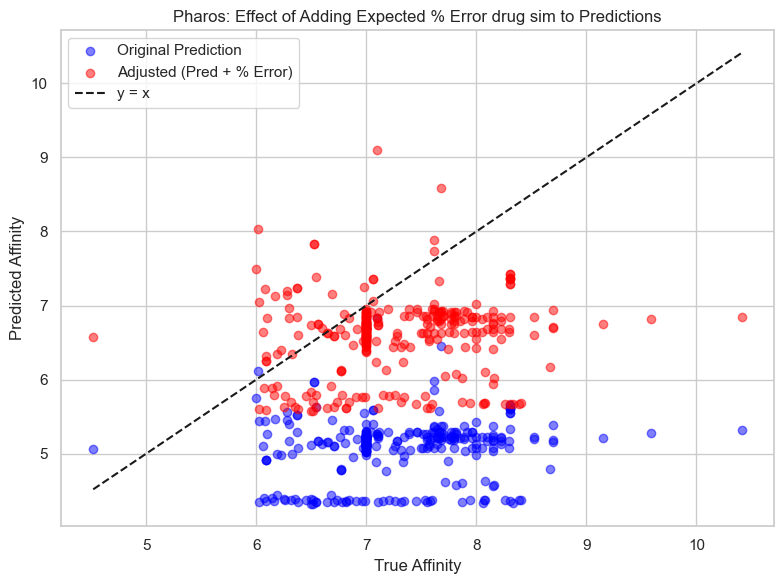

In [200]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

true = pharos_df["True_Label"]
original = pharos_df["Predicted_Value"]
adjusted = pharos_df["Adjusted_Prediction_Drug"]

rmse_orig = np.sqrt(mean_squared_error(true, original))
mae_orig = mean_absolute_error(true, original)
rmse_adj = np.sqrt(mean_squared_error(true, adjusted))
mae_adj = mean_absolute_error(true, adjusted)

print(f"🔵 Original Prediction:  RMSE={rmse_orig:.3f}, MAE={mae_orig:.3f}")
print(f"🔴 Adjusted Prediction:  RMSE={rmse_adj:.3f}, MAE={mae_adj:.3f}")
plt.figure(figsize=(8, 6))

# Original points
plt.scatter(
    pharos_df["True_Label"],
    pharos_df["Predicted_Value"],
    color="blue",
    alpha=0.5,
    label="Original Prediction"
)

# Adjusted points
plt.scatter(
    pharos_df["True_Label"],
    pharos_df["Adjusted_Prediction_Drug"],
    color="red",
    alpha=0.5,
    label="Adjusted (Pred + % Error)"
)

# y = x line
min_val = min(pharos_df["True_Label"].min(), pharos_df["Adjusted_Prediction_Drug"].min())
max_val = max(pharos_df["True_Label"].max(), pharos_df["Adjusted_Prediction_Drug"].max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label="y = x")

# Labels
plt.xlabel("True Affinity")
plt.ylabel("Predicted Affinity")
plt.title("Pharos: Effect of Adding Expected % Error drug sim to Predictions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [201]:
print(pharos_df.columns)

Index(['Drug_ID', 'Protein_ID', 'True_Label', 'Predicted_Value',
       'Protein_Similarity', 'Inferred_ERS', 'ERS_Confidence',
       'Inferred_CSVS_alt', 'ERS', 'Percent_Error', 'Expected_Error',
       'Adjusted_Prediction', 'Expected_Error_Protein',
       'Adjusted_Prediction_Protein', 'Drug_Similarity', 'Expected_Error_Drug',
       'Adjusted_Prediction_Drug', 'Similarity_Bin'],
      dtype='object')


In [202]:
# 1. Define bins
affinity_bins = [4, 5, 6, 7, 8, 9, 10]

pharos_df["Affinity_Bin"] = pd.cut(pharos_df["Predicted_Value"], bins=affinity_bins)

# 2. Compute mean signed error per bin on DAVIS
bin_means = (
    df
    .assign(Affinity_Bin=pd.cut(df["Predicted_Value"], bins=affinity_bins))
    .groupby("Affinity_Bin")["Percent_Error"]
    .mean()
)

# 3. Apply to Pharos
pharos_df = pharos_df.assign(
    Affinity_Bin=pd.cut(pharos_df["Predicted_Value"], bins=affinity_bins),
    Bin_Correction=pharos_df["Affinity_Bin"].map(bin_means).astype(float)  # Convert to float
)

# 4. Apply multiplicative correction (matches drug similarity approach)
pharos_df["Bin_Adjusted"] = pharos_df["Predicted_Value"] * (1 + pharos_df["Bin_Correction"] / 100)

# 5. (Optional) Evaluate against true labels if available
if "True_Label" in pharos_df:
    true = pharos_df["True_Label"]
    original = pharos_df["Predicted_Value"]
    adjusted = pharos_df["Bin_Adjusted"]
    
    rmse_orig = np.sqrt(mean_squared_error(true, original))
    mae_orig = mean_absolute_error(true, original)
    rmse_adj = np.sqrt(mean_squared_error(true, adjusted))
    mae_adj = mean_absolute_error(true, adjusted)
    
    print(f"🔵 Original Prediction:  RMSE={rmse_orig:.3f}, MAE={mae_orig:.3f}")
    print(f"🟢 Bin-Adjusted Prediction:  RMSE={rmse_adj:.3f}, MAE={mae_adj:.3f}")


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_97690/2128740276.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("Affinity_Bin")["Percent_Error"]


🔵 Original Prediction:  RMSE=2.312, MAE=2.193
🟢 Bin-Adjusted Prediction:  RMSE=1.009, MAE=0.819


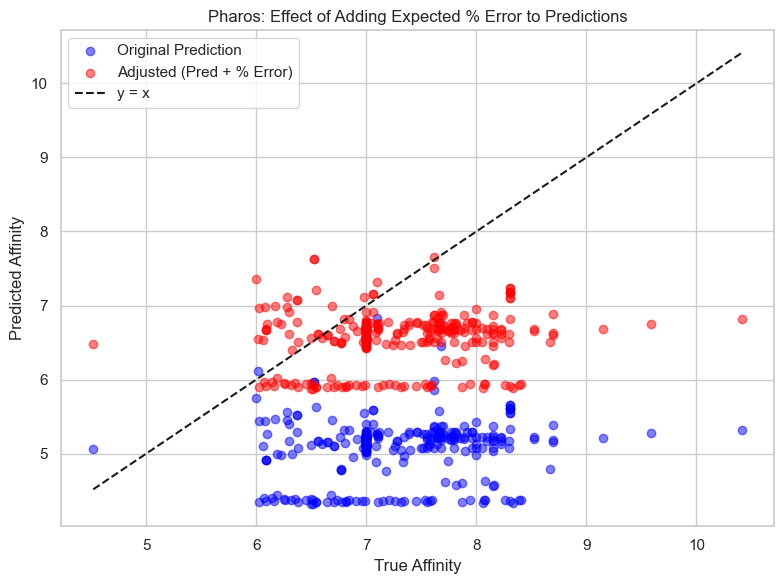

In [203]:
plt.figure(figsize=(8, 6))

# Original points
plt.scatter(
    pharos_df["True_Label"],
    pharos_df["Predicted_Value"],
    color="blue",
    alpha=0.5,
    label="Original Prediction"
)

# Adjusted points
plt.scatter(
    pharos_df["True_Label"],
    pharos_df["Bin_Adjusted"],
    color="red",
    alpha=0.5,
    label="Adjusted (Pred + % Error)"
)

# y = x line
min_val = min(pharos_df["True_Label"].min(), pharos_df["Bin_Adjusted"].min())
max_val = max(pharos_df["True_Label"].max(), pharos_df["Bin_Adjusted"].max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label="y = x")

# Labels
plt.xlabel("True Affinity")
plt.ylabel("Predicted Affinity")
plt.title("Pharos: Effect of Adding Expected % Error to Predictions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()